# Test the dPIEMD and PIEMD from lenstool's C code

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

## 0 Define the class and key function of these two mass profiles

In [2]:
from typing import Tuple
import numpy as np

import autoarray as aa
from autogalaxy.profiles.mass.abstract.abstract import MassProfile

def _ci05(x, y, eps, rcore):
    """
    Returns the first derivatives of the lens potential as complex number I'* = (∂ψ/∂x + i ∂ψ/∂y) / E0 for PIEMD at any positions (x,y), 
    see Kassiola & Kovner(1993) Eq. 4.1.2, which is the integral of Eq. 2.3.8.
    Note here b0(or called E0) is out of the `_ci05`.

    Parameters
    ----------
    eps
        The ellipticity of the corresponding profiles.
    rcore
        The inner core radius.
    Returns
    -------
    complex
        The value of the I'* term.
    """
    if eps < 1e-10:
        eps = 1e-10
    sqe = np.sqrt(eps)
    axis_ratio = (1.0 - eps) / (1.0 + eps)
    cxro = (1.0 + eps) * (1.0 + eps)
    cyro = (1.0 - eps) * (1.0 - eps)
    rem2 = x * x / cxro + y * y / cyro
    ##### I'* = zres = zci * ln(zis) = zci * ln(znum / zden), see Eq. 4.1.2 #####

    # Define intermediate complex variables
    zci = np.complex128(complex(0.0, -0.5 * (1.0 - eps * eps) / sqe))
    znum = np.complex128(axis_ratio * x + 1j * (2.0 * sqe * np.sqrt(rcore * rcore + rem2) - y / axis_ratio))
    zden = np.complex128(x + 1j * (2.0 * rcore * sqe - y))
        
    # zis = znum / zden = (a+bi)/(c+di) = [(ac+bd)+(bc-ad i)] / (c^2+d^2)
    norm = zden.real * zden.real + zden.imag * zden.imag  # |zden|^2
    zis_re = (znum.real * zden.real + znum.imag * zden.imag) / norm
    zis_im = (znum.imag * zden.real - znum.real * zden.imag) / norm
    zis = np.complex128(zis_re + 1j * zis_im)
    
    # ln(zis) = ln(|zis|) + i*Arg(zis)
    zis_mag = np.abs(zis)
    zis_re = np.log(zis_mag)
    zis_im = np.angle(zis)
    zis = np.complex128(zis_re + 1j * zis_im)
    
    # I'* = zres = zci * ln(zis)
    zres = zci * zis
    
    return zres

def _ci05f(x, y, eps, rcore, rcut):
    """
    Returns the first derivatives of the lens potential as complex number I'* = (∂ψ/∂x + i ∂ψ/∂y) / (b0 * ra / (rs - ra)) for dPIEMD at any positions (x,y), 
    which is the integral of Eq. 2.3.8 in  Kassiola & Kovner(1993). 
    
    Note here (b0 * ra / (rs - ra)) is out of the `_ci05f`. The only difference of integral of Eq. 2.3.8 between dPIEMD and PIEMD is the \\kappa:
    \\kappa(r_{em})_{dPIEMD} = rs / (rs - ra) * (\\kappa_{PIEMD,ra} - \\kappa_{PIEMD,rs}).
    I*_{dPIEMD} = ra / (rs - ra) * (I*_{PIEMD}(ra) - I*_{PIEMD}(ra))

    Parameters
    ----------
    eps
        The ellipticity of the corresponding profiles.
    rcore
        The inner core radius.
    rcut
        The outer cut radius.
    Returns
    -------
    complex
        The value of the I'* term.
    """
    if eps < 1e-10:
        eps = 1e-10
    sqe = np.sqrt(eps)
    axis_ratio = (1.0 - eps) / (1.0 + eps)
    cxro = (1.0 + eps) * (1.0 + eps)
    cyro = (1.0 - eps) * (1.0 - eps)
    rem2 = x * x / cxro + y * y / cyro

    ##### I'* = zres_rc - zres_rcut = zci * ln(zis_rc / zis_rcut) = zci * ln((znum_rc / zden_rc) / (znum_rcut / zden_rcut)) #####

    # Define intermediate complex variables
    zci = np.complex128(complex(0.0, -0.5 * (1.0 - eps * eps) / sqe))
    znum_rc = np.complex128(axis_ratio * x + 1j * (2.0 * sqe * np.sqrt(rcore * rcore + rem2) - y / axis_ratio)) # a + bi
    zden_rc = np.complex128(x + 1j * (2.0 * rcore * sqe - y)) # c + di
    znum_rcut = np.complex128(axis_ratio * x + 1j * (2.0 * sqe * np.sqrt(rcut * rcut + rem2) - y / axis_ratio)) # a + ei
    zden_rcut = np.complex128(x + 1j * (2.0 * rcut * sqe - y)) # c + fi

    # zis_rc = znum_rc / zden_rc = (a+bi)/(c+di)
    # zis_rcut = znum_rcut / zden_rcut = (a+ei)/(c+fi)
    # zis_tot = zis_rc / zis_rcut = (znum_rc / zden_rc) / (znum_rcut / zden_rcut)
    #                             = [(ac - bf) + (af + bc)i] / [(ac - de) + (ad + ce)i]
    #                             = (aa + bb*i) / (cc + dd*i)
    #                             = (aa + bb*i) * (cc -dd*i) / (cc^2 + dd^2)
    #                             = [(aa*cc + bb*dd) / (cc^ + dd^2)] + [(bb*cc - aa*dd) / (cc^2 + dd^2)]*i
    #                             =                 aaa              +                 bbb*i
    aa = znum_rc.real * zden_rc.real - znum_rc.imag * zden_rcut.imag # ac - bf
    bb = znum_rc.real * zden_rcut.imag + znum_rc.imag * zden_rc.real # af + bc
    cc = znum_rc.real * zden_rc.real - zden_rc.imag * znum_rcut.imag # ac - de
    dd = znum_rc.real * zden_rc.imag + zden_rc.real * znum_rcut.imag # ad + ce
    norm = cc * cc + dd * dd
    aaa = (aa * cc + bb * dd) / norm
    bbb = (bb * cc - aa * dd) / norm
    zis_tot = np.complex128(aaa + 1j * bbb)

    # ln(zis_tot) = ln(|zis_tot|) + i*Arg(zis_tot)
    zis_tot_mag = np.abs(zis_tot)
    zr_re = np.log(zis_tot_mag)
    zr_im = np.angle(zis_tot)
    zr = np.complex128(zr_re + 1j * zr_im)

    # I'* = zci * ln(zis_tot)
    zres = zci * zr

    return zres

def _mdci05(x, y, eps, rcore, b0):
    """
    Returns the second derivatives (Hessian matrix) of the lens potential as complex number for PIEMD at any positions (x,y):
    ∂²ψ/∂x² = Re(∂I*/∂x), ∂²ψ/∂y² = Im(∂I*/∂y), ∂²ψ/∂x∂y = ∂²ψ/∂y∂x = Im(∂I*/∂x) = Re(∂I*/∂y)
    see Kassiola & Kovner(1993) Eq. 4.1.4.

    Parameters
    ----------
    eps
        The ellipticity of the corresponding profiles.
    rcore
        The inner core radius.
    Returns
    -------
    complex
        The value of the I'* term.
    """
    if eps < 1e-10:
        eps = 1e-10

    # Calculate intermediate values
    # I*(x,y) = b0 * ci * (-i) * (ln{ q * x + (2.0 * sqe * wrem - y * 1/q )*i} - ln{ x + (2.0 * rcore * sqe - y)*i})
    #         = b0 * ci * (-i) * (ln{ q * x + num1*i} - ln{ x + num2*i})
    #         = b0 * ci * (-i) * (ln{u(x,y)} - ln{v(x,y)})
    sqe = np.sqrt(eps)
    axis_ratio = (1.0 - eps) / (1.0 + eps)
    axis_ratio_inv = 1.0 / axis_ratio
    cxro = (1.0 + eps) * (1.0 + eps)
    cyro = (1.0 - eps) * (1.0 - eps)
    ci = 0.5 * (1.0 - eps * eps) / sqe
    wrem = np.sqrt(rcore * rcore + x * x / cxro + y * y / cyro) # √(w(x,y))
    num1 = 2.0 * sqe * wrem - y * axis_ratio_inv
    den1 = axis_ratio * axis_ratio * x * x + num1 * num1 # |q * x + num1*i|^2
    num2 = 2.0 * rcore * sqe - y
    den2 = x * x + num2 * num2 # |x + num2*i|^2

    # eg. 
    # ∂²ψ/∂x² = Re(∂I*/∂x) = b0 * didxre
    # ∂I*/∂x = b0 * ci * (-i) * ∂(ln{u(x,y)} - ln{v(x,y)})∂x
    #        = b0 * ci * (-i) * (1/u * ∂u/∂x - 1/v * ∂v/∂x)
    # ∂u/∂x = q + ∂(num1)/∂x * i
    #       = q + [2.0 * sqe * ∂(wrem)/∂x] * i
    #       = q + [2.0 * sqe * ∂(√(w(x,y)))/∂x] * i
    #       = q + [2.0 * sqe * x / cxro / wrem] * i
    # 1/u * ∂u/∂x = {q + [2.0 * sqe * x / cxro / wrem] * i}  /  {q * x + num1*i}
    #             = {q + [2.0 * sqe * x / cxro / wrem] * i} * {q * x - num1*i}  /  |q * x + num1*i|^2
    #             = {q + [2.0 * sqe * x / cxro / wrem] * i} * {q * x - (2.0 * sqe * wrem - y / q)*i}  /  den1
    #             = {q^2 * x + 4.0 * sqe^2 * x - y / q * 2.0 * sqe * x / cxro / wrem} / den1 + q * { (2.0 * sqe * x^2 / cxro / wrem) - (2.0 * sqe * wrem - y / q)} / den1 * i
    #             = {x - 2.0 * sqe * x * y * q / cyro / wrem} / den1 + q * { (2.0 * sqe * x^2 / cxro / wrem) - (2.0 * sqe * wrem - y / q)} / den1 * i
    # (-i) * (1/u * ∂u/∂x) = (2.0 * sqe * x * y * q / cyro / wrem - x) / den1 * i 
    #                      + q * { (2.0 * sqe * x^2 / cxro / wrem) - (2.0 * sqe * wrem - y / q)} / den1
    # ∂v/∂x = 1 + ∂(num2)/∂x * i
    #       = 1
    # 1/v * ∂v/∂x = 1 / (x + num2*i)
    #             = (x - num2*i) / |x + num2*i|^2
    #             = (x - num2*i) / den2
    # -(-i) * (1/v * ∂v/∂x) = (x*i + num2) / den2

    # ∂I*/∂x = b0 * ci * {(-i) * (1/u * ∂u/∂x) - (-i) * (1/v * ∂v/∂x)}

    # Compute second derivatives
    didxre = ci * (
        axis_ratio * (2.0 * sqe * x * x / cxro / wrem - 2.0 * sqe * wrem + y * axis_ratio_inv) / den1
        + num2 / den2
    )
    didyre = ci * (
        (2.0 * sqe * x * y * axis_ratio / cyro / wrem - x) / den1
        + x / den2
    )
    didyim = ci * (
        (2.0 * sqe * wrem * axis_ratio_inv - y * axis_ratio_inv * axis_ratio_inv - 4.0 * eps * y / cyro
        + 2.0 * sqe * y * y / cyro / wrem * axis_ratio_inv) / den1
        - num2 / den2
    )

    # Construct Hessian matrix components
    a = b0 * didxre  # ∂²ψ/∂x²
    b = b0 * didyre  # ∂²ψ/∂x∂y
    c = b0 * didyre  # ∂²ψ/∂y∂x
    d = b0 * didyim  # ∂²ψ/∂y²

    return a,b,c,d

class PIEMD(MassProfile):
    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        ell_comps: Tuple[float, float] = (0.0, 0.0),
        ra: float = 0.1,
        b0: float = 0.1,
    ):
        """
        The Pseudo Isothermal Elliptical Mass Distribution(PIEMD) profiles, based on the formulaiton from 
        Kassiola & Kovner(1993) https://articles.adsabs.harvard.edu/pdf/1993ApJ...417..450K.
        This profile is ported from Lenstool's C code, which has the same formulation.

        This proflie describes an elliptic isothermal mass distribution with a finite core: 
        \\rho \\propto (ra^2 + R^2)^{-1}

        The convergence is given by:
        \\kappa(r_{em}) = \\kappa_0 * ra / \\sqrt{ ra^2 + r_{em}^2 }
        (see Kassiola & Kovner(1993), Eq. 4.1.1)
        where r_{em}^2 = x^2 / (1 + \\epsilon)^2 + y^2 / (1 - \\epsilon)^2, (see Kassiola & Kovner(1993), Eq. 2.3.6)
        and \\kappa_0 = b_0 / 2 / r_a. 

        In this implementation:
        - `ra` is the core radius in unit of arcseconds.
        - `b0` is the lens strength in unit of arcseconds, when ra->0 & q->1, b0 is the Einstein radius. 
          `b0` is related to the central velocity dispersion \\sigma_0: b_0 = 4\\pi * \\sigma_0^2 / c^2 * (D_{LS} / D_{S}).
          `b0` is not in the Intermediate-Axis-Convention for its r_{em}^2 = x^2 / (1 + \\epsilon)^2 + y^2 / (1 - \\epsilon)^2

        Parameters
        ----------
        centre
            The (y,x) arc-second coordinates of the profile centre.
        ra
            The inner core radius in arcseconds.
        b0
            The lens strength in arcseconds.
        """
        super().__init__(centre=centre, ell_comps=ell_comps)

        self.ra = ra
        self.b0 = b0
    
    def _ellip(self):
        ellip = np.sqrt(self.ell_comps[0] ** 2 + self.ell_comps[1] ** 2)
        MAX_ELLIP = 0.99999
        return min(ellip, MAX_ELLIP)
    
    @aa.grid_dec.to_vector_yx
    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def deflections_yx_2d_from(self, grid: aa.type.Grid2DLike, **kwargs):
        """
        Calculate the deflection angles on a grid of (y,x) arc-second coordinates.

        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the deflection angles are computed on.
        """
        ellip = self._ellip()
        factor = self.b0
        zis = _ci05(x=grid[:, 1], y=grid[:, 0], eps=ellip, rcore=self.ra)

        # This is in axes aligned to the major/minor axis
        deflection_x = zis.real
        deflection_y = zis.imag

        # And here we convert back to the real axes
        return self.rotated_grid_from_reference_frame_from(
            grid=np.multiply(factor, np.vstack((deflection_y, deflection_x)).T), **kwargs
        )

    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def analytical_hessian_2d_from(self, grid: 'aa.type.Grid2DLike', **kwargs):
        """
        Calculate the hessian matrix on a grid of (y,x) arc-second coordinates.

        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the deflection angles are computed on.
        """
        grid = np.asarray(grid)
        if grid.ndim != 2 or grid.shape[1] != 2:
            raise ValueError("Grid must be a 2D array with shape (n, 2)")
        ellip = self._ellip()

        hessian_xx, hessian_xy, hessian_yx, hessian_yy = _mdci05(
            x=grid[:, 1], y=grid[:, 0], eps=ellip, rcore=self.ra, b0=self.b0
        )

        return hessian_yy, hessian_xy, hessian_yx, hessian_xx
    
    def analytical_magnification_2d_from(self, grid: 'aa.type.Grid2DLike', **kwargs):

        hessian_yy, hessian_xy, hessian_yx, hessian_xx = self.analytical_hessian_2d_from(
            grid=grid
        )

        det_A = (1 - hessian_xx) * (1 - hessian_yy) - hessian_xy * hessian_yx

        return aa.Array2D(values=1.0 / det_A, mask=grid.mask)
    
class dPIEMD(MassProfile):
    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        ell_comps: Tuple[float, float] = (0.0, 0.0),
        ra: float = 0.0,
        rs: float = 2.0,
        b0: float = 0.1,
    ):
        """
        The dual Pseudo Isothermal Elliptical Mass Distribution(dPIEMD) profiles, which is a *two component PIEMD* with both a core radius and a truncation radius, 
        see Eliasdottir (2007): https://arxiv.org/abs/0710.5636
        This profile is ported from Lenstool's C code, which has the same formulation.

        This proflie describes an elliptic isothermal mass distribution with a finite core, \\rho \~ r^{-2} while in the transition region (ra<=R<=rs), 
        and \\rho \~ r^{-4} in the outer parts: 
        \\rho \\propto [(ra^2 + R^2) (rs^2 + R^2)]^{-1}

        The convergence is given by two PIEMD with core radius ra and rs: 
        \\kappa(r_{em}) = rs / (rs - ra) * (\\kappa_{PIEMD,ra} - \\kappa_{PIEMD,rs})
                        = b_0 / 2 * rs / (rs - ra) * ( \\frac{1}{\\sqrt{ ra^2 + r_{em}^2}} - \\frac{1}{\\sqrt{ rs^2 + r_{em}^2}} )
        where r_{em}^2 = x^2 / (1 + \\epsilon)^2 + y^2 / (1 - \\epsilon)^2. 
        Note in Eliasdottir (2007), E0 = 6\\pi * \\sigma_{dPIE}^2 / c^2 * (D_{LS} / D_{S}). Eliasdottir's E0 is not the same as E0 in Kassiola & Kovner(1993) which is also b0.
        There is \\frac{\\sigma_{dPIE}^2}{\\sigma_0^2} = \\frac{2}{3} \frac{rs^2}{rs^2-ra^2}, 
        thus E0(Kassiola & Kovner(1993)) = b0 = E0(Eliasdottir (2007)) * (rs^2 - ra^2) / rs^2. So when s->\\infty and a->0, they are equivalent.

        In this implementation:
        - `ra` is the core radius in unit of arcseconds.
        - `rs` is the truncation radius in unit of arcseconds.
        - `b0` is the lens strength in unit of arcseconds, when ra->0 & rs->\\infty & q->1, b0 is the Einstein radius. 
          `b0` is related to the central velocity dispersion \\sigma_0: b_0 = 4\\pi * \\sigma_0^2 / c^2 * (D_{LS} / D_{S})
          `b0` is not in the Intermediate-Axis-Convention for its r_{em}^2 = x^2 / (1 + \\epsilon)^2 + y^2 / (1 - \\epsilon)^2

        Parameters
        ----------
        centre
            The (y,x) arc-second coordinates of the profile centre.
        ra
            The inner core radius in arcseconds.
        rs
            The outer truncation radius in arcseconds.
        b0
            The lens strength in arcseconds.
        """
        super().__init__(centre=centre, ell_comps=ell_comps)

        if ra > rs:
            ra, rs = rs, ra

        self.ra = ra
        self.rs = rs
        self.b0 = b0
    
    def _ellip(self):
        ellip = np.sqrt(self.ell_comps[0] ** 2 + self.ell_comps[1] ** 2)
        MAX_ELLIP = 0.99999
        return min(ellip, MAX_ELLIP)
    
    @aa.grid_dec.to_vector_yx
    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def deflections_yx_2d_from(self, grid: aa.type.Grid2DLike, **kwargs):
        """
        Calculate the deflection angles on a grid of (y,x) arc-second coordinates.

        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the deflection angles are computed on.
        """
        ellip = self._ellip()
        factor = self.b0 * self.rs / (self.rs - self.ra)
        zis = _ci05f(
            x=grid[:, 1], y=grid[:, 0], eps=ellip, rcore=self.ra, rcut=self.rs
        )

        # This is in axes aligned to the major/minor axis
        deflection_x = zis.real
        deflection_y = zis.imag

        # And here we convert back to the real axes
        return self.rotated_grid_from_reference_frame_from(
            grid=np.multiply(factor, np.vstack((deflection_y, deflection_x)).T), **kwargs
        )
    
    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def analytical_hessian_2d_from(self, grid: 'aa.type.Grid2DLike', **kwargs):
        """
        Calculate the hessian matrix on a grid of (y,x) arc-second coordinates.
        Hessian_dPIEMD = rs * (rs - ra) * ( Hessian_PIEMD(ra) - Hessian_PIEMD(rs))

        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the deflection angles are computed on.
        """
        grid = np.asarray(grid)
        if grid.ndim != 2 or grid.shape[1] != 2:
            raise ValueError("Grid must be a 2D array with shape (n, 2)")
        ellip = self._ellip()
        
        t05 = self.rs / (self.rs - self.ra)
        g05c_a, g05c_b, g05c_c, g05c_d = _mdci05(
            x=grid[:, 1], y=grid[:, 0], eps=ellip, rcore=self.ra, b0=self.b0
        )
        g05cut_a, g05cut_b, g05cut_c, g05cut_d = _mdci05(
            x=grid[:, 1], y=grid[:, 0], eps=ellip, rcore=self.rs, b0=self.b0
        )

        # Compute Hessian matrix components
        hessian_xx = t05 * (g05c_a - g05cut_a)
        hessian_xy = t05 * (g05c_b - g05cut_b)
        hessian_yx = t05 * (g05c_c - g05cut_c)
        hessian_yy = t05 * (g05c_d - g05cut_d)

        return hessian_yy, hessian_xy, hessian_yx, hessian_xx
    
    def analytical_magnification_2d_from(self, grid: 'aa.type.Grid2DLike', **kwargs):
        
        hessian_yy, hessian_xy, hessian_yx, hessian_xx = self.analytical_hessian_2d_from(
            grid=grid
        )

        det_A = (1 - hessian_xx) * (1 - hessian_yy) - hessian_xy * hessian_yx

        return aa.Array2D(values=1.0 / det_A, mask=grid.mask)
    
class dPIEMDSph(dPIEMD):
    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        ra: float = 0.1,
        rs: float = 2.0,
        b0: float = 1.0
    ):
        """
        The dual Pseudo Isothermal Elliptical Mass Distribution(dPIEMD) profiles without ellipticity, which is a *two component PIEMD* with both a core radius and a truncation radius, 
        see Eliasdottir (2007): https://arxiv.org/abs/0710.5636
        This profile is ported from Lenstool's C code, which has the same formulation.

        This proflie describes an spherical isothermal mass distribution with a finite core, \\rho \~ r^{-2} while in the transition region (ra<=R<=rs), 
        and \\rho \~ r^{-4} in the outer parts: 
        \\rho \\propto [(ra^2 + R^2) (rs^2 + R^2)]^{-1}

        The convergence is given by two PIEMD with core radius ra and rs: 
        \\kappa(r_{em}) = rs / (rs - ra) * (\\kappa_{PIEMD,ra} - \\kappa_{PIEMD,rs})
                        = b_0 / 2 * rs / (rs - ra) * ( \\frac{1}{\\sqrt{ ra^2 + r_{em}^2}} - \\frac{1}{\\sqrt{ rs^2 + r_{em}^2}} )
        where r_{em}^2 = x^2 / (1 + \\epsilon)^2 + y^2 / (1 - \\epsilon)^2. 
        Note in Eliasdottir (2007), E0 = 6\\pi * \\sigma_{dPIE}^2 / c^2 * (D_{LS} / D_{S}). Eliasdottir's E0 is not the same as E0 in Kassiola & Kovner(1993) which is also b0.
        There is \\frac{\\sigma_{dPIE}^2}{\\sigma_0^2} = \\frac{2}{3} \frac{rs^2}{rs^2-ra^2}, 
        thus E0(Kassiola & Kovner(1993)) = b0 = E0(Eliasdottir (2007)) * (rs^2 - ra^2) / rs^2. So when s->\\infty and a->0, they are equivalent.

        In this implementation:
        - `ra` is the core radius in unit of arcseconds.
        - `rs` is the truncation radius in unit of arcseconds.
        - `b0` is the lens strength in unit of arcseconds, when ra->0 & rs->\\infty & q->1, b0 is the Einstein radius. 
          `b0` is related to the central velocity dispersion \\sigma_0: b_0 = 4\\pi * \\sigma_0^2 / c^2 * (D_{LS} / D_{S})
          `b0` is not in the Intermediate-Axis-Convention for its r_{em}^2 = x^2 / (1 + \\epsilon)^2 + y^2 / (1 - \\epsilon)^2

        Parameters
        ----------
        centre
            The (y,x) arc-second coordinates of the profile centre.
        ra
            The inner core radius in arcseconds.
        rs
            The outer truncation radius in arcseconds.
        b0
            The lens strength in arcseconds.
        """
        super().__init__(centre=centre, ell_comps=(0.0, 0.0))
        if ra > rs:
            ra, rs = rs, ra
        self.ra = ra
        self.rs = rs
        self.b0 = b0

    @aa.grid_dec.to_vector_yx
    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def deflections_yx_2d_from(self, grid: aa.type.Grid2DLike, **kwargs):
        """
        Calculate the deflection angles on a grid of (y,x) arc-second coordinates.
        Faster and equivalent to Eliasdottir (2007), see Eq. A19 and Eq. A20. 

        f(R,a,s) = {R/a} / {1 + \\sqrt{1 + (R/a)^2}} - {R/s} / {1 + \\sqrt{1 + (R/s)^2}}
                 = R / {\\sqrt{a^2 + R^2} + a} - R / {\\sqrt{s^2 + R^2} + s}
                 = R * (\\sqrt{a^2 + R^2} - a) / {a^2 + R^2 - a^2} - R * (\\sqrt{s^2 + R^2} - s) / {s^2 + R^2 - s^2}
                 = (\\sqrt{R^2 + a^2} - a - \\sqrt{R^2 + s^2} + s) / R
        \\alpha = b0 * s / (s - a) * f(R,a,s)
        deflection_x = \\alpha * grid[:, 1] / R
                     = grid[:, 1] * b0 * s / (s - a) * (\\sqrt{R^2 + a^2} - a - \\sqrt{R^2 + s^2} + s) / R^2
        deflection_y = \\alpha * grid[:, 0] / R
                     = grid[:, 0] * b0 * s / (s - a) * (\\sqrt{R^2 + a^2} - a - \\sqrt{R^2 + s^2} + s) / R^2

        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the deflection angles are computed on.
        """
        a = self.ra
        s = self.rs
        # radii = self.radial_grid_from(grid=grid, **kwargs)
        # R2 = radii * radii
        R2 = grid[:, 1] * grid[:, 1] + grid[:, 0] * grid[:, 0]
        factor = np.sqrt(R2 + a * a) - a - np.sqrt(R2 + s * s) + s
        factor *= self.b0 * s / (s - a) / R2

        # This is in axes aligned to the major/minor axis
        deflection_x = grid[:, 1] * factor
        deflection_y = grid[:, 0] * factor

        # And here we convert back to the real axes
        return self.rotated_grid_from_reference_frame_from(
            grid=np.multiply(1.0, np.vstack((deflection_y, deflection_x)).T), **kwargs
        )
    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def analytical_hessian_2d_from(self, grid: 'aa.type.Grid2DLike', **kwargs):
        """
        Calculate the hessian matrix on a grid of (y,x) arc-second coordinates.
        Chain rule of second derivatives: 
        ∂²ψ/∂x² = ∂²ψ/∂R² * (∂R/∂x)² + ∂²R/∂x² * ∂ψ/∂R
        ∂²ψ/∂y² = ∂²ψ/∂R² * (∂R/∂y)² + ∂²R/∂y² * ∂ψ/∂R
        ∂²ψ/∂x∂y = ∂²ψ/∂R² * ∂R/∂x * ∂R/∂y + ∂²R/∂x∂y * ∂ψ/∂R


        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the deflection angles are computed on.
        """
        grid = np.asarray(grid)
        if grid.ndim != 2 or grid.shape[1] != 2:
            raise ValueError("Grid must be a 2D array with shape (n, 2)")

        a = self.ra
        s = self.rs
        t05 = self.b0 * s / (s - a)

        # We have known the first derivatives as `deflections_yx`:
        # ∂ψ/∂R ∝ f(R,a,s) = (\\sqrt{R^2 + a^2} - a - \\sqrt{R^2 + s^2} + s) / R = z / R
        # ∂ψ/∂x ∝ x * (\\sqrt{R^2 + a^2} - a - \\sqrt{R^2 + s^2} + s) / R^2 = x * z / R^2
        # ∂ψ/∂y ∝ y * (\\sqrt{R^2 + a^2} - a - \\sqrt{R^2 + s^2} + s) / R^2 = y * z / R^2

        # where z = (\\sqrt{R^2 + a^2} - a - \\sqrt{R^2 + s^2} + s) / R^2

        # R = (x^2 + y^2)^(0.5)
        # ∂R/∂x = x / R
        # ∂R/∂y = y / R
        # ∂²R/∂²x = y^2 / R^3
        # ∂²R/∂²y = x^2 / R^3
        # ∂²R/∂x∂y = - x*y / R^3

        # ∂²ψ/∂²R = ∂(z/R)/∂R = (∂z/∂R * R - z * 1) / R^2
        #                     = {( R^2 / √(R^2 + a^2)) - ( R^2 / √(R^2 + s^2)) - z} / R^2
        #                     = p
        R2 = grid[:, 1] * grid[:, 1] + grid[:, 0] * grid[:, 0]
        z = np.sqrt(R2 + a * a) - a - np.sqrt(R2 + s * s) + s
        p = (1.0 - a / np.sqrt(a * a + R2)) * a / R2 - (1.0 - s / np.sqrt(s * s + R2)) * s / R2
        X = grid[:, 1] * grid[:, 1] / R2 # x^2 / R^2
        Y = grid[:, 0] * grid[:, 0] / R2 # y^2 / R^2
        XY = grid[:, 1] * grid[:, 0] / R2 # x*y / R^2

        # ∂²ψ/∂x²  = ∂²ψ/∂R² * (∂R/∂x)² + ∂²R/∂x² * ∂ψ/∂R
        #          = p * (x / R)^2 + y^2 / R^3 * z / R
        #          = p * x^2 / R^2 + z * y^2 / R^2 / R^2
        #          = p * X + z * Y / R2
        # ∂²ψ/∂y²  = ∂²ψ/∂R² * (∂R/∂y)² + ∂²R/∂y² * ∂ψ/∂R
        #          = p * (y / R)^2 + x^2 / R^3 * z / R
        #          = p * y^2 / R^2 + z * x^2 / R^2 / R^2
        #          = p * Y + z * X / R2
        # ∂²ψ/∂x∂y = ∂²ψ/∂R² * ∂R/∂x * ∂R/∂y + ∂²R/∂x∂y * ∂ψ/∂R
        #          = p * (x / R) * (y / R) + (- x*y / R^3) * z / R
        #          = p * x*y / R^2 - z * x*y / R^2 / R^2
        #          = p * XY + z * XY / R2

        # Compute Hessian matrix components
        hessian_xx = t05 * (p * X + z * Y / R2)
        hessian_xy = t05 * (p * XY - z * XY / R2)
        hessian_yx = t05 * (p * XY - z * XY / R2)
        hessian_yy = t05 * (p * Y + z * X / R2)

        return hessian_yy, hessian_xy, hessian_yx, hessian_xx

In [3]:
class dPIEP(MassProfile):

    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        ell_comps: Tuple[float, float] = (0.0, 0.0),
        ra: float = 0.1,
        rs: float = 2.0,
        b0: float = 1.0,
    ):
        """
        The dual Pseudo Isothermal Elliptical Potential (dPIEP) with pseudo-ellipticity on potential, based on the
        formulation from Eliasdottir (2007): https://arxiv.org/abs/0710.5636.

        This profile describes a circularly symmetric (non-elliptical) projected mass
        distribution with two scale radii (`ra` and `rs`) and a normalization factor
        `kappa_scale`. Although originally called the dPIE (Elliptical), this version
        lacks ellipticity, so the "E" may be a misnomer.

        The projected surface mass density is given by:

        .. math::

            \\Sigma(R) = \\Sigma_0 (ra * rs) / (rs - ra) *
                          (1 / \\sqrt(ra^2 + R^2) - 1 / \\sqrt(rs^2 + R^2))

        (See Eliasdottir 2007, Eq. A3.)

        In this implementation:
        - `ra` is the core radius in unit of arcseconds.
        - `b0` is the lens strength in unit of arcseconds, when ra->0 & rs->\\infty & q->1, b0 is the Einstein radius. 
          `b0` is related to the central velocity dispersion \\sigma_0: b_0 = 4\\pi * \\sigma_0^2 / c^2 * (D_{LS} / D_{S})
          `b0` is not in the Intermediate-Axis-Convention for its r_{em}^2 = x^2 / (1 + \\epsilon)^2 + y^2 / (1 - \\epsilon)^2

        Credit: Jackson O'Donnell for implementing this profile in PyAutoLens.

        Parameters
        ----------
        centre
            The (y,x) arc-second coordinates of the profile centre.
        ra
            The inner core scale radius in arcseconds.
        rs
            The outer truncation scale radius in arcseconds.
        b0
            The lens strength in arcseconds.
        """
        super().__init__(centre=centre, ell_comps=ell_comps)

        if ra > rs:
            ra, rs = rs, ra

        self.ra = ra
        self.rs = rs
        self.b0 = b0

    def _ellip(self):
        ellip = np.sqrt(self.ell_comps[0] ** 2 + self.ell_comps[1] ** 2)
        MAX_ELLIP = 0.99999
        return min(ellip, MAX_ELLIP)

    def _deflection_angle(self, radii):
        """
        For a circularly symmetric dPIE profile, computes the magnitude of the deflection at each radius.
        """
        a, s = self.ra, self.rs
        radii = np.maximum(radii, 1e-8)
        f = (
            radii / (a + np.sqrt(a**2 + radii**2))
            - radii / (s + np.sqrt(s**2 + radii**2))
        )

        # c.f. Eliasdottir '07 eq. A23
        # magnitude of deflection
        # alpha = self.E0 * (s + a) / s * f
        alpha = self.b0 * s / (s - a) * f
        return alpha

    def _convergence(self, radii):
        radsq = radii * radii
        a, s = self.ra, self.rs
        # c.f. Eliasdottir '07 eqn (A3)
        # return (
        #     self.E0 / 2 * (s + a) / s *
        #     (1/np.sqrt(a**2 + radsq) - 1/np.sqrt(s**2 + radsq))
        # )
        return (
            self.b0 / 2 * s / (s - a) *
            (1/np.sqrt(a**2 + radsq) - 1/np.sqrt(s**2 + radsq))
        )

    @aa.grid_dec.to_vector_yx
    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def deflections_yx_2d_from(self, grid: aa.type.Grid2DLike, **kwargs):
        """
        Calculate the deflection angles on a grid of (y,x) arc-second coordinates.

        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the deflection angles are computed on.
        """
        ellip = self._ellip()
        grid_radii = np.sqrt(
            grid[:, 1] ** 2 * (1 - ellip) + grid[:, 0] ** 2 * (1 + ellip)
        )

        # Compute the deflection magnitude of a *non-elliptical* profile
        alpha_circ = self._deflection_angle(grid_radii)

        # This is in axes aligned to the major/minor axis
        deflection_y = alpha_circ * np.sqrt(1 + ellip) * (grid[:, 0] / grid_radii)
        deflection_x = alpha_circ * np.sqrt(1 - ellip) * (grid[:, 1] / grid_radii)

        # And here we convert back to the real axes
        return self.rotated_grid_from_reference_frame_from(
            grid=np.multiply(1.0, np.vstack((deflection_y, deflection_x)).T), **kwargs
        )

    @aa.grid_dec.to_vector_yx
    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def convergence_2d_from(self, grid: aa.type.Grid2DLike, **kwargs):
        """
        Returns the two dimensional projected convergence on a grid of (y,x) arc-second coordinates.

        The `grid_2d_to_structure` decorator reshapes the ndarrays the convergence is outputted on. See
        *aa.grid_2d_to_structure* for a description of the output.

        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the convergence is computed on.
        """
        ellip = self._ellip()
        grid_radii = np.sqrt(
            grid[:, 1] ** 2 * (1 - ellip) + grid[:, 0] ** 2 * (1 + ellip)
        )

        # Compute the convergence and deflection of a *circular* profile
        kappa_circ = self._convergence(grid_radii)
        alpha_circ = self._deflection_angle(grid_radii)

        asymm_term = (
            ellip * (1 - ellip) * grid[:, 1] ** 2
            - ellip * (1 + ellip) * grid[:, 0] ** 2
        ) / grid_radii**2

        # convergence = 1/2 \nabla \alpha = 1/2 \nabla^2 potential
        # The "asymm_term" is asymmetric on x and y, so averages out to
        # zero over all space
        return kappa_circ * (1 - asymm_term) + (alpha_circ / grid_radii) * asymm_term

    @aa.grid_dec.to_array
    def potential_2d_from(self, grid: aa.type.Grid2DLike, **kwargs):
        return np.zeros(shape=grid.shape[0])


class dPIEPSph(dPIEP):

    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        ra: float = 0.1,
        rs: float = 2.0,
        b0: float = 1.0,
    ):
        """
        The dual Pseudo-Isothermal mass profile (dPIE) without ellipticity, based on the
        formulation from Eliasdottir (2007): https://arxiv.org/abs/0710.5636.

        This profile describes a circularly symmetric (non-elliptical) projected mass
        distribution with two scale radii (`ra` and `rs`) and a normalization factor
        `kappa_scale`. Although originally called the dPIE (Elliptical), this version
        lacks ellipticity, so the "E" may be a misnomer.

        The projected surface mass density is given by:

        .. math::

            \\Sigma(R) = \\Sigma_0 (ra * rs) / (rs - ra) *
                          (1 / \\sqrt(ra^2 + R^2) - 1 / \\sqrt(rs^2 + R^2))

        (See Eliasdottir 2007, Eq. A3.)

        In this implementation:
        - `ra` is the core radius in unit of arcseconds.
        - `b0` is the lens strength in unit of arcseconds, when ra->0 & rs->\\infty & q->1, b0 is the Einstein radius. 
          `b0` is related to the central velocity dispersion \\sigma_0: b_0 = 4\\pi * \\sigma_0^2 / c^2 * (D_{LS} / D_{S})
          `b0` is not in the Intermediate-Axis-Convention for its r_{em}^2 = x^2 / (1 + \\epsilon)^2 + y^2 / (1 - \\epsilon)^2

        Credit: Jackson O'Donnell for implementing this profile in PyAutoLens.

        Parameters
        ----------
        centre
            The (y,x) arc-second coordinates of the profile centre.
        ra
            The inner core scale radius in arcseconds.
        rs
            The outer truncation scale radius in arcseconds.
        b0
            The lens strength in arcseconds.
        """

        # Ensure rs > ra (things will probably break otherwise)
        if ra > rs:
            ra, rs = rs, ra

        super().__init__(centre=centre, ell_comps=(0.0, 0.0))

        self.ra = ra
        self.rs = rs
        self.b0 = b0

    @aa.grid_dec.to_vector_yx
    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def deflections_yx_2d_from(self, grid: aa.type.Grid2DLike, **kwargs):
        """
        Calculate the deflection angles on a grid of (y,x) arc-second coordinates.

        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the deflection angles are computed on.
        """
        radii = self.radial_grid_from(grid=grid, **kwargs)

        alpha = self._deflection_angle(radii)

        # now we decompose the deflection into y/x components
        defl_y = alpha * grid[:, 0] / radii
        defl_x = alpha * grid[:, 1] / radii

        return aa.Grid2DIrregular.from_yx_1d(defl_y, defl_x)

    @aa.grid_dec.to_array
    @aa.grid_dec.transform
    @aa.grid_dec.relocate_to_radial_minimum
    def convergence_2d_from(self, grid: aa.type.Grid2DLike, **kwargs):
        """
        Returns the two dimensional projected convergence on a grid of (y,x) arc-second coordinates.

        The `grid_2d_to_structure` decorator reshapes the ndarrays the convergence is outputted on. See
        *aa.grid_2d_to_structure* for a description of the output.

        Parameters
        ----------
        grid
            The grid of (y,x) arc-second coordinates the convergence is computed on.
        """
        # already transformed to center on profile centre so this works
        radsq = grid[:, 0] ** 2 + grid[:, 1] ** 2

        return self._convergence(np.sqrt(radsq))

    @aa.grid_dec.to_array
    def potential_2d_from(self, grid: aa.type.Grid2DLike, **kwargs):
        return np.zeros(shape=grid.shape[0])


## 1 Comparison between dPIEMD with dPIEP
> PIEMD and dPIEMD should not have the peanut-shaped mass distribution which is not physical.

In [4]:
import autolens as al
import autofit as af
grid = al.Grid2D.uniform(
    shape_native=(70, 70),
    pixel_scales=0.04,
)

### 1.1 Test deflection angle

#### 1.1.1 Vector Field

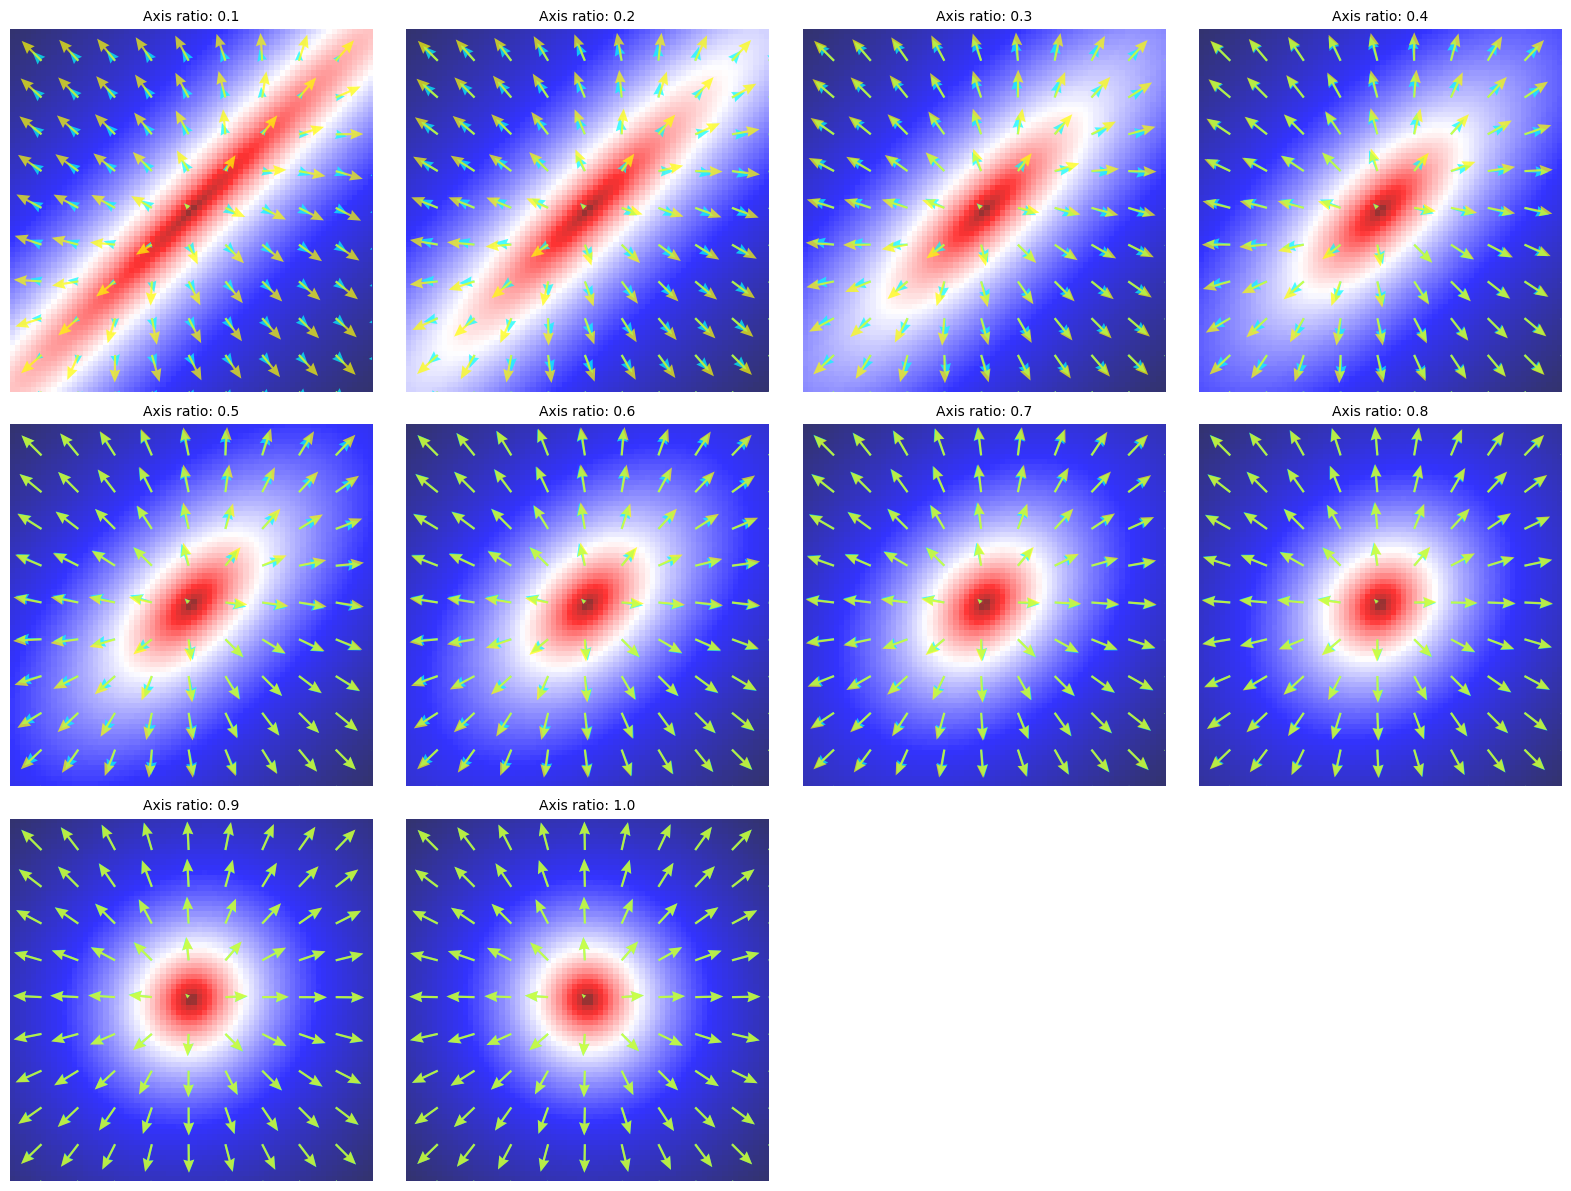

In [5]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

sampling_step = 7
x_sample = xgrid[::sampling_step, ::sampling_step]
y_sample = ygrid[::sampling_step, ::sampling_step]
arrow_scale = 0.25
head_width = 5
head_length = 6

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)

    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.1,rs=10.0, b0=1.0
    )
    mass_dpiep=dPIEP(
        centre=(0, 0), ell_comps=ell_comps,
        ra = 0.1, rs=10.0,
        b0=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)


    deflections_dpiemd = mass_dpiemd.deflections_yx_2d_from(grid=grid).native
    deflections_dpiep = mass_dpiep.deflections_yx_2d_from(grid=grid).native
    model_image_test = bulge.image_2d_from(grid=grid).native

    deflections_x_dpiemd = deflections_dpiemd[::sampling_step, ::sampling_step, 0]
    deflections_y_dpiemd = deflections_dpiemd[::sampling_step, ::sampling_step, 1]

    deflections_x_dpiep = deflections_dpiep[::sampling_step, ::sampling_step, 0]
    deflections_y_dpiep = deflections_dpiep[::sampling_step, ::sampling_step, 1]

    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    ax.quiver(
        x_sample, y_sample, deflections_x_dpiemd, deflections_y_dpiemd,
        color="cyan",
        scale=1 / arrow_scale,
        scale_units="xy",
        headwidth=head_width,
        headlength=head_length,
        headaxislength=head_length * 0.9,
        alpha=0.7
    )

    ax.quiver(
        x_sample, y_sample, deflections_x_dpiep, deflections_y_dpiep,
        color="yellow",
        scale=1 / arrow_scale,
        scale_units="xy",
        headwidth=head_width,
        headlength=head_length,
        headaxislength=head_length * 0.9,
        alpha=0.7
    )

    ax.imshow(
        model_image_test, norm="log", cmap="seismic", extent=ext, alpha=0.8
    )

    ax.set_title(f"Axis ratio: {axis_ratio}", fontsize=10)

    ax.axis("off")
for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()


#### 1.1.2 Residual(X)

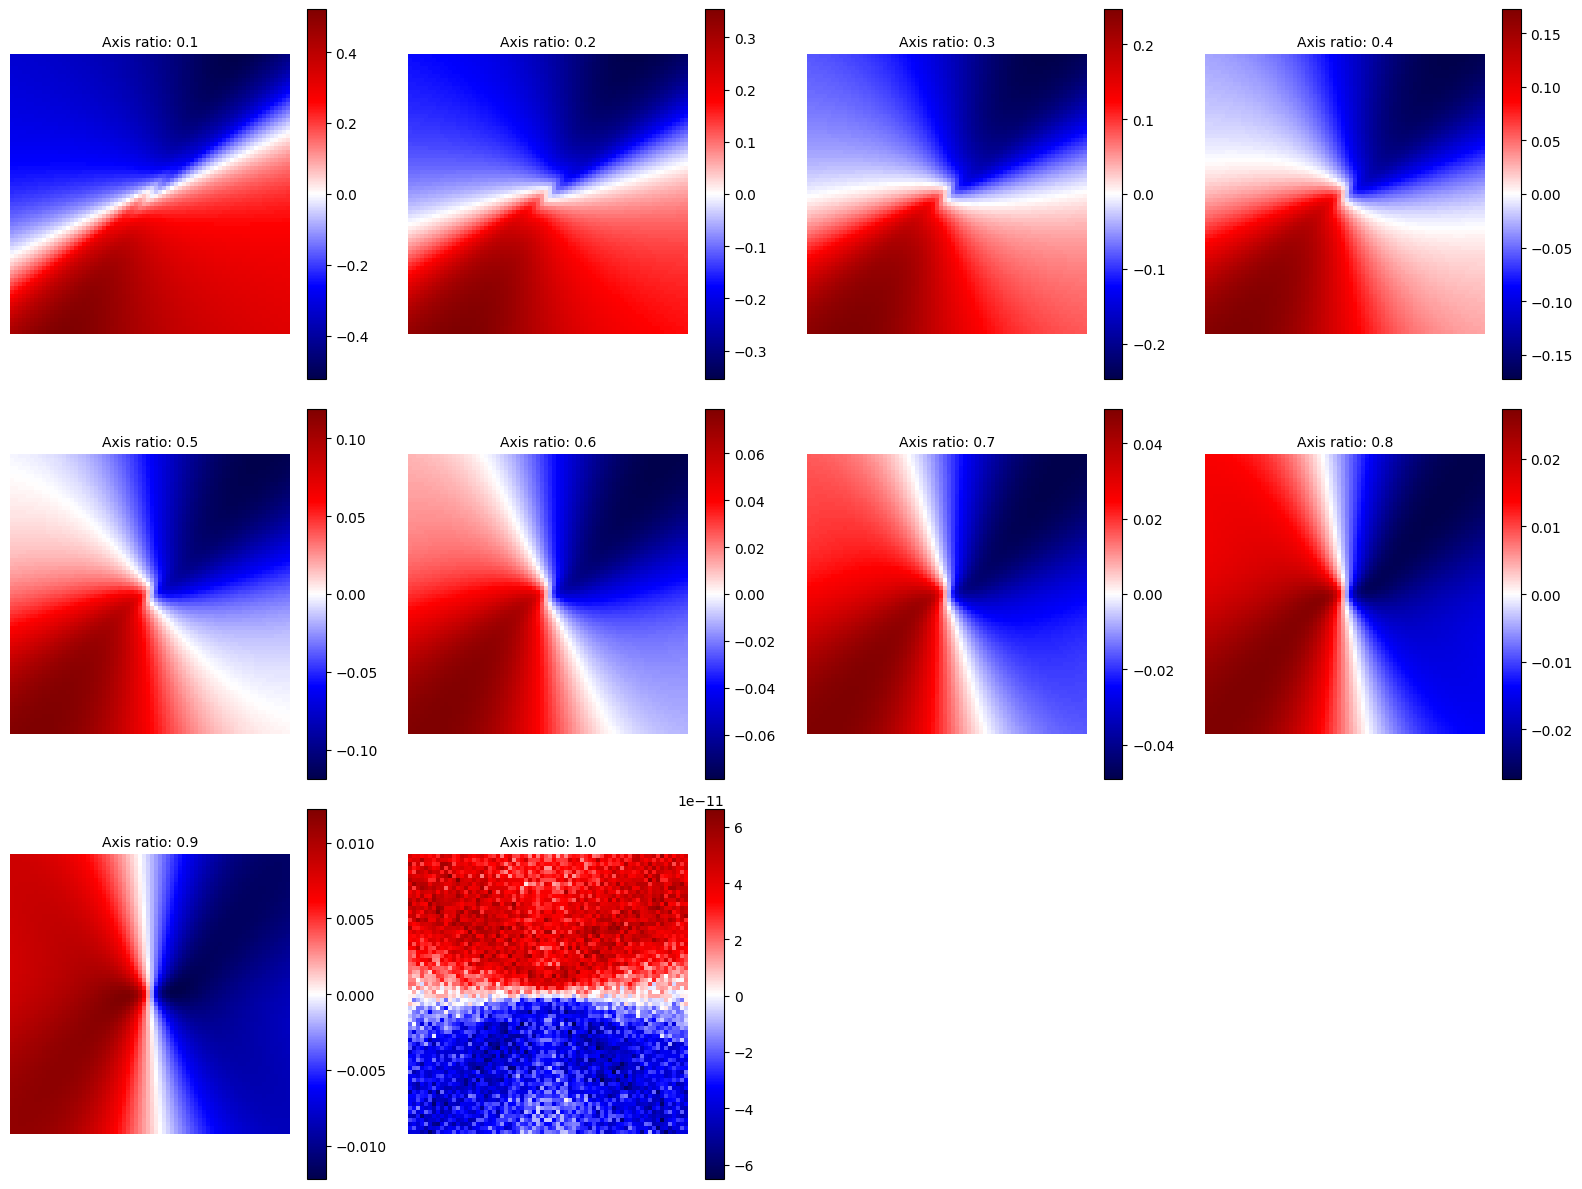

In [6]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

sampling_step = 7
x_sample = xgrid[::sampling_step, ::sampling_step]
y_sample = ygrid[::sampling_step, ::sampling_step]
arrow_scale = 0.25
head_width = 5
head_length = 6

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)


    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.1,rs=10.0, b0=1.0
    )
    mass_dpiep=dPIEP(
        centre=(0, 0), ell_comps=ell_comps,
        ra = 0.1, rs=10.0,
        b0=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)


    deflections_dpiemd = mass_dpiemd.deflections_yx_2d_from(grid=grid).native
    deflections_dpiep = mass_dpiep.deflections_yx_2d_from(grid=grid).native
    model_image_test = bulge.image_2d_from(grid=grid).native

    deflections_x_dpiemd = deflections_dpiemd[:,:, 0]
    deflections_y_dpiemd = deflections_dpiemd[:,:, 1]

    deflections_x_dpiep = deflections_dpiep[:,:, 0]
    deflections_y_dpiep = deflections_dpiep[:,:, 1]

    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    img = ax.imshow(
        deflections_x_dpiemd - deflections_x_dpiep, norm="linear", cmap="seismic", extent=ext,
    )

    ax.set_title(f"Axis ratio: {axis_ratio}", fontsize=10)
    fig.colorbar(img, ax=ax)

    ax.axis("off")
for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()


#### 1.1.3 Residual(Y)

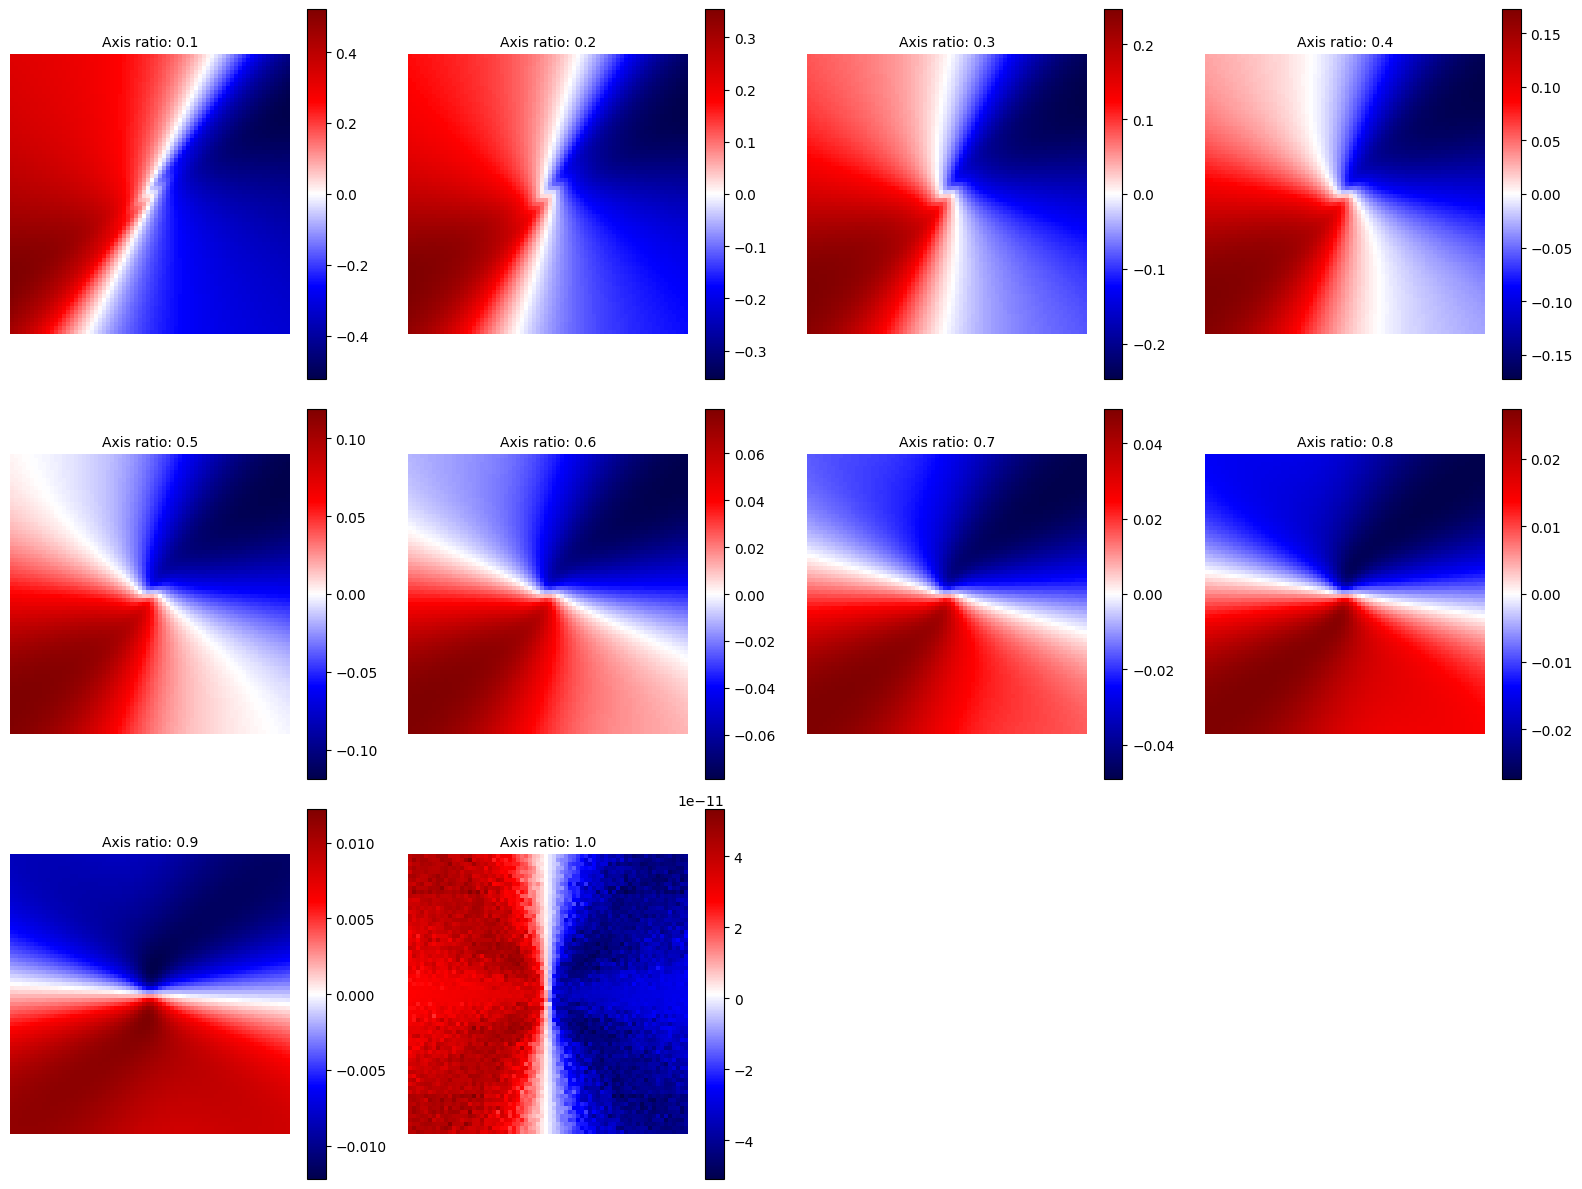

In [7]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

sampling_step = 7
x_sample = xgrid[::sampling_step, ::sampling_step]
y_sample = ygrid[::sampling_step, ::sampling_step]
arrow_scale = 0.25
head_width = 5
head_length = 6

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)


    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.1,rs=10.0, b0=1.0
    )
    mass_dpiep=dPIEP(
        centre=(0, 0), ell_comps=ell_comps,
        ra = 0.1, rs=10.0,
        b0=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)


    deflections_dpiemd = mass_dpiemd.deflections_yx_2d_from(grid=grid).native
    deflections_dpiep = mass_dpiep.deflections_yx_2d_from(grid=grid).native
    model_image_test = bulge.image_2d_from(grid=grid).native

    deflections_x_dpiemd = deflections_dpiemd[:,:, 0]
    deflections_y_dpiemd = deflections_dpiemd[:,:, 1]

    deflections_x_dpiep = deflections_dpiep[:,:, 0]
    deflections_y_dpiep = deflections_dpiep[:,:, 1]

    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    img = ax.imshow(
        deflections_y_dpiemd - deflections_y_dpiep, norm="linear", cmap="seismic", extent=ext,
    )

    ax.set_title(f"Axis ratio: {axis_ratio}", fontsize=10)
    fig.colorbar(img, ax=ax)

    ax.axis("off")
for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()


### 1.2 Test $\kappa$ map

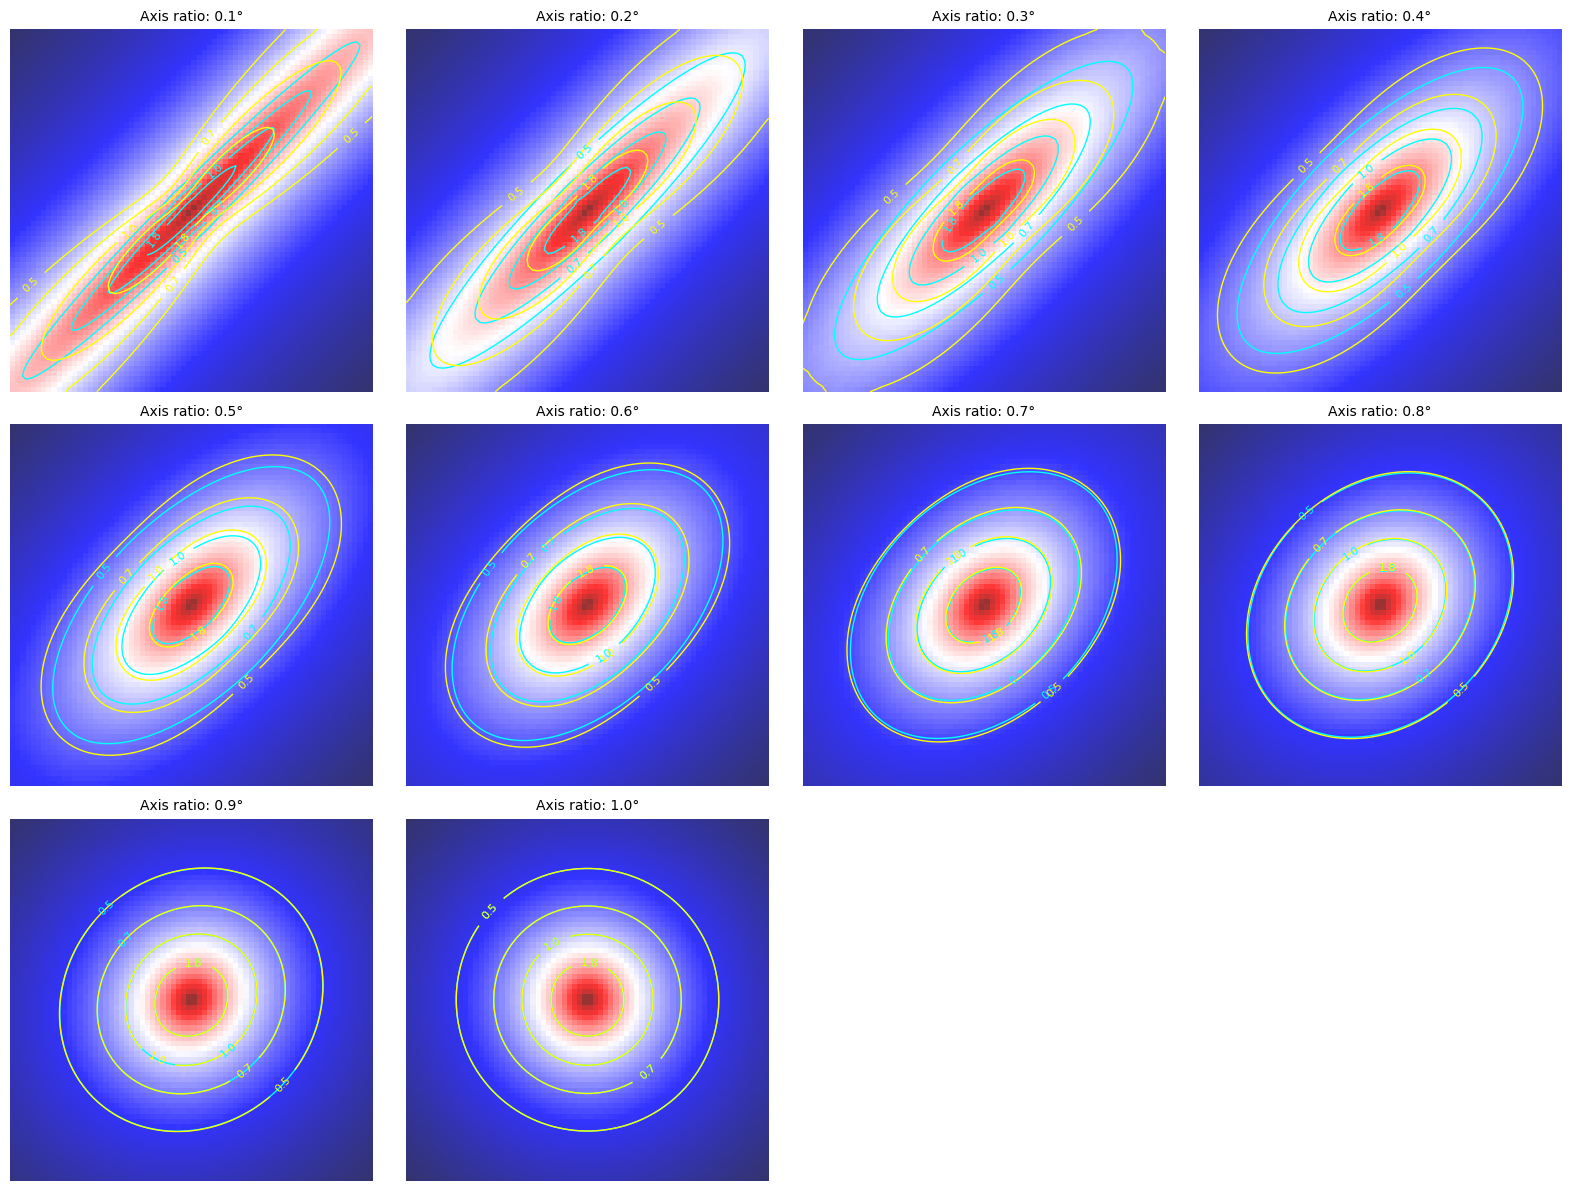

In [8]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45
arr = np.array([0.5,0.7,1.0, 1.8])

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)

    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.0,rs=1e8, b0=1.0
    )
    mass_dpiep=dPIEP(
        centre=(0, 0), ell_comps=ell_comps,
        ra = 0.0, rs=1e8,
        b0=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

    kappa_map_dpiemd = mass_dpiemd.convergence_2d_via_jacobian_from(grid=grid).native
    kappa_map_dpiep = mass_dpiep.convergence_2d_via_jacobian_from(grid=grid).native
    model_image_test = bulge.image_2d_from(grid=grid).native


    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    contours_0 = ax.contour(
        ygrid, xgrid, kappa_map_dpiemd, colors="cyan", levels=arr, linewidths=1.0
    )
    contours_1 = ax.contour(
        ygrid, xgrid, kappa_map_dpiep, colors="yellow", levels=arr, linewidths=1.0
    )

    ax.clabel(contours_0, inline=True, fontsize=8)
    ax.clabel(contours_1, inline=True, fontsize=8)


    ax.set_title(f"Axis ratio: {axis_ratio}°", fontsize=10)
    ax.imshow(
        model_image_test, norm="log", cmap="seismic", extent=ext, alpha=0.8
    )
    ax.axis("off") 

for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

### 1.3 Test lensed image

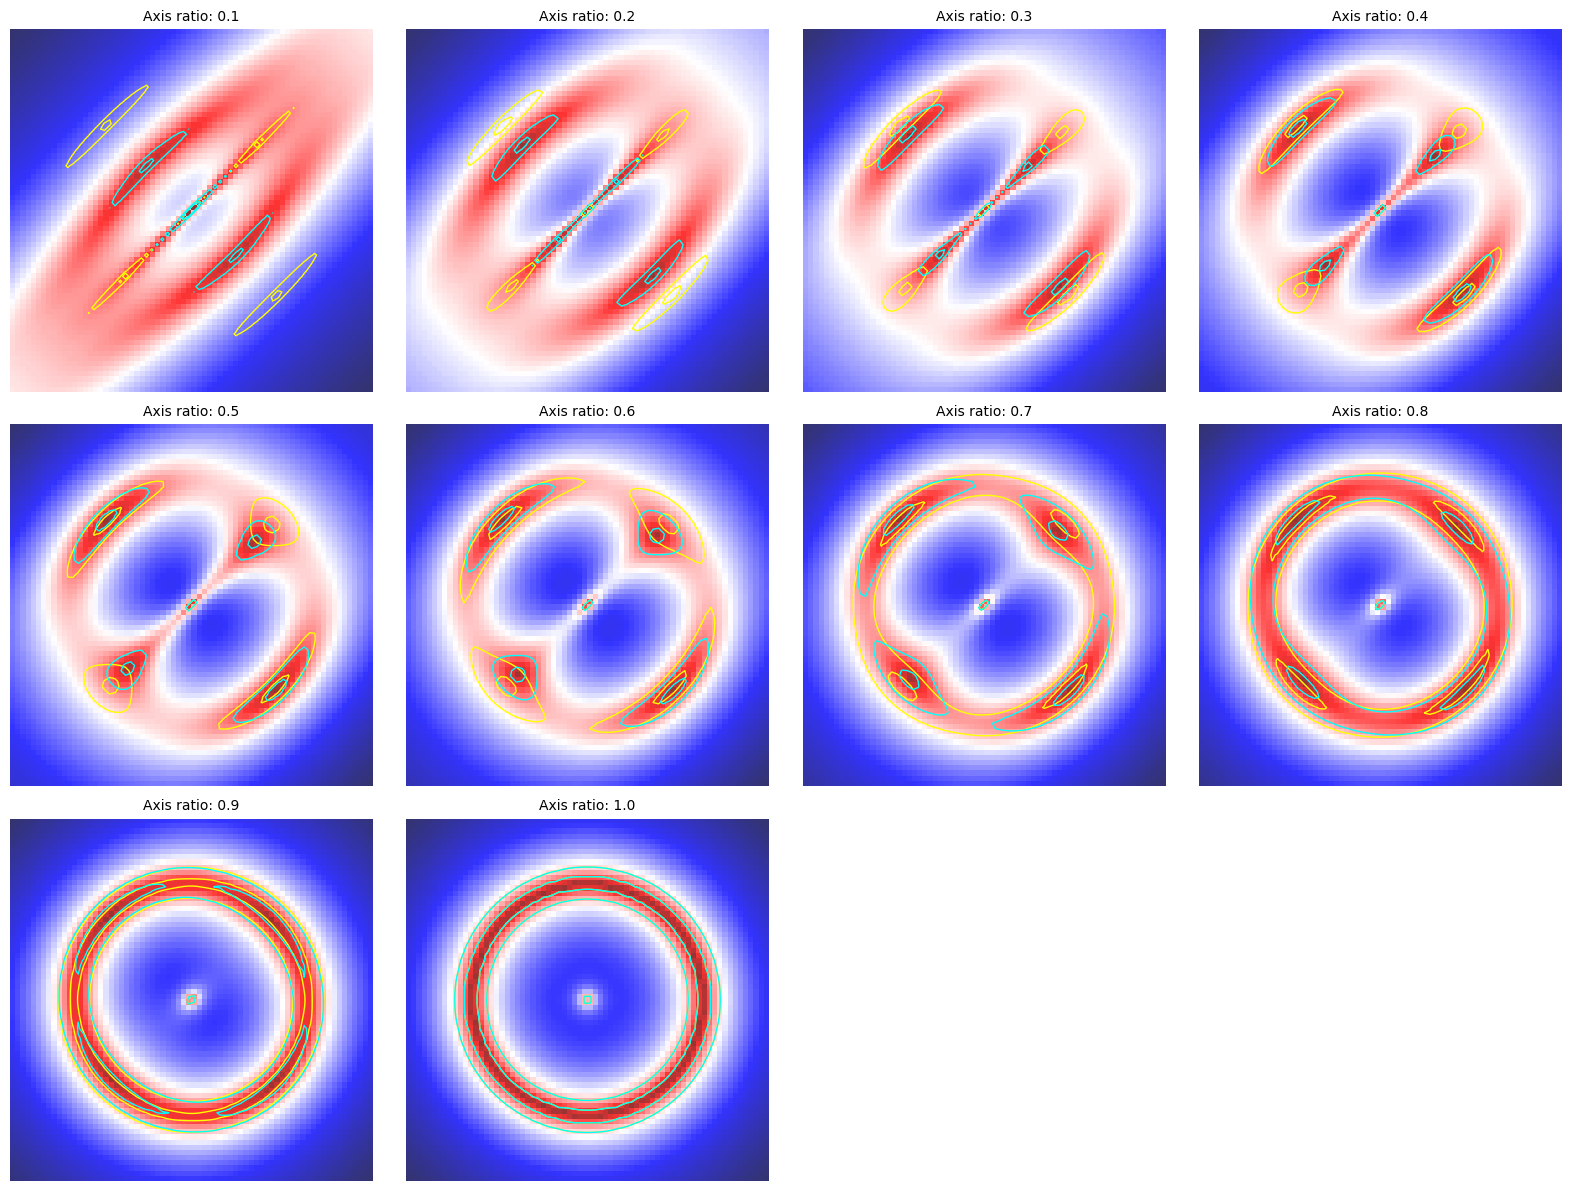

In [9]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45
# arr = np.array([1.0, 1.8])

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)

fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

for i, q in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=q, angle=angle)

    tracer_temp_dpiemd = al.Tracer(
        galaxies=af.Collection(
            lens=al.Galaxy(
                redshift=0.5,
                mass_dpie=dPIEMD(
                    centre=(0, 0), ell_comps=ell_comps,
                    ra=0.1, rs=100, b0=1.0
                ),
            ),
            source=al.Galaxy(
                redshift=1.0,
                bulge = al.lp.Sersic(centre=(0,0),ell_comps=ell_comps)
            )
        )
    )
    tracer_temp_dpiep = al.Tracer(
        galaxies=af.Collection(
            lens=al.Galaxy(
                redshift=0.5,
                mass_sie=dPIEP(
                    centre=(0, 0), ell_comps=ell_comps,
                    ra=0.1, rs=100, b0=1.0
                ),
            ),
            source=al.Galaxy(
                redshift=1.0,
                bulge = al.lp.Sersic(centre=(0,0),ell_comps=ell_comps)
            )
        )
    )
    
    model_arc_test_dpiemd = tracer_temp_dpiemd.image_2d_from(grid=grid).native
    model_arc_test_dpiep = tracer_temp_dpiep.image_2d_from(grid=grid).native

 
    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]
    ax.imshow(
        model_arc_test_dpiemd, norm="log", cmap="seismic", extent=ext, alpha=0.8
    )
    arr = np.array([1.5,5.0])
    contours_sie = ax.contour(
        ygrid, xgrid, model_arc_test_dpiep, colors="yellow", levels=arr, linewidths=1.0
    )
    contours_dpie = ax.contour(
        ygrid, xgrid, model_arc_test_dpiemd, colors="cyan", levels=arr, linewidths=1.0
    )


    ax.set_title(f"Axis ratio: {q}", fontsize=10)

    ax.axis("off")

for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

### 1.4 Test magnification map

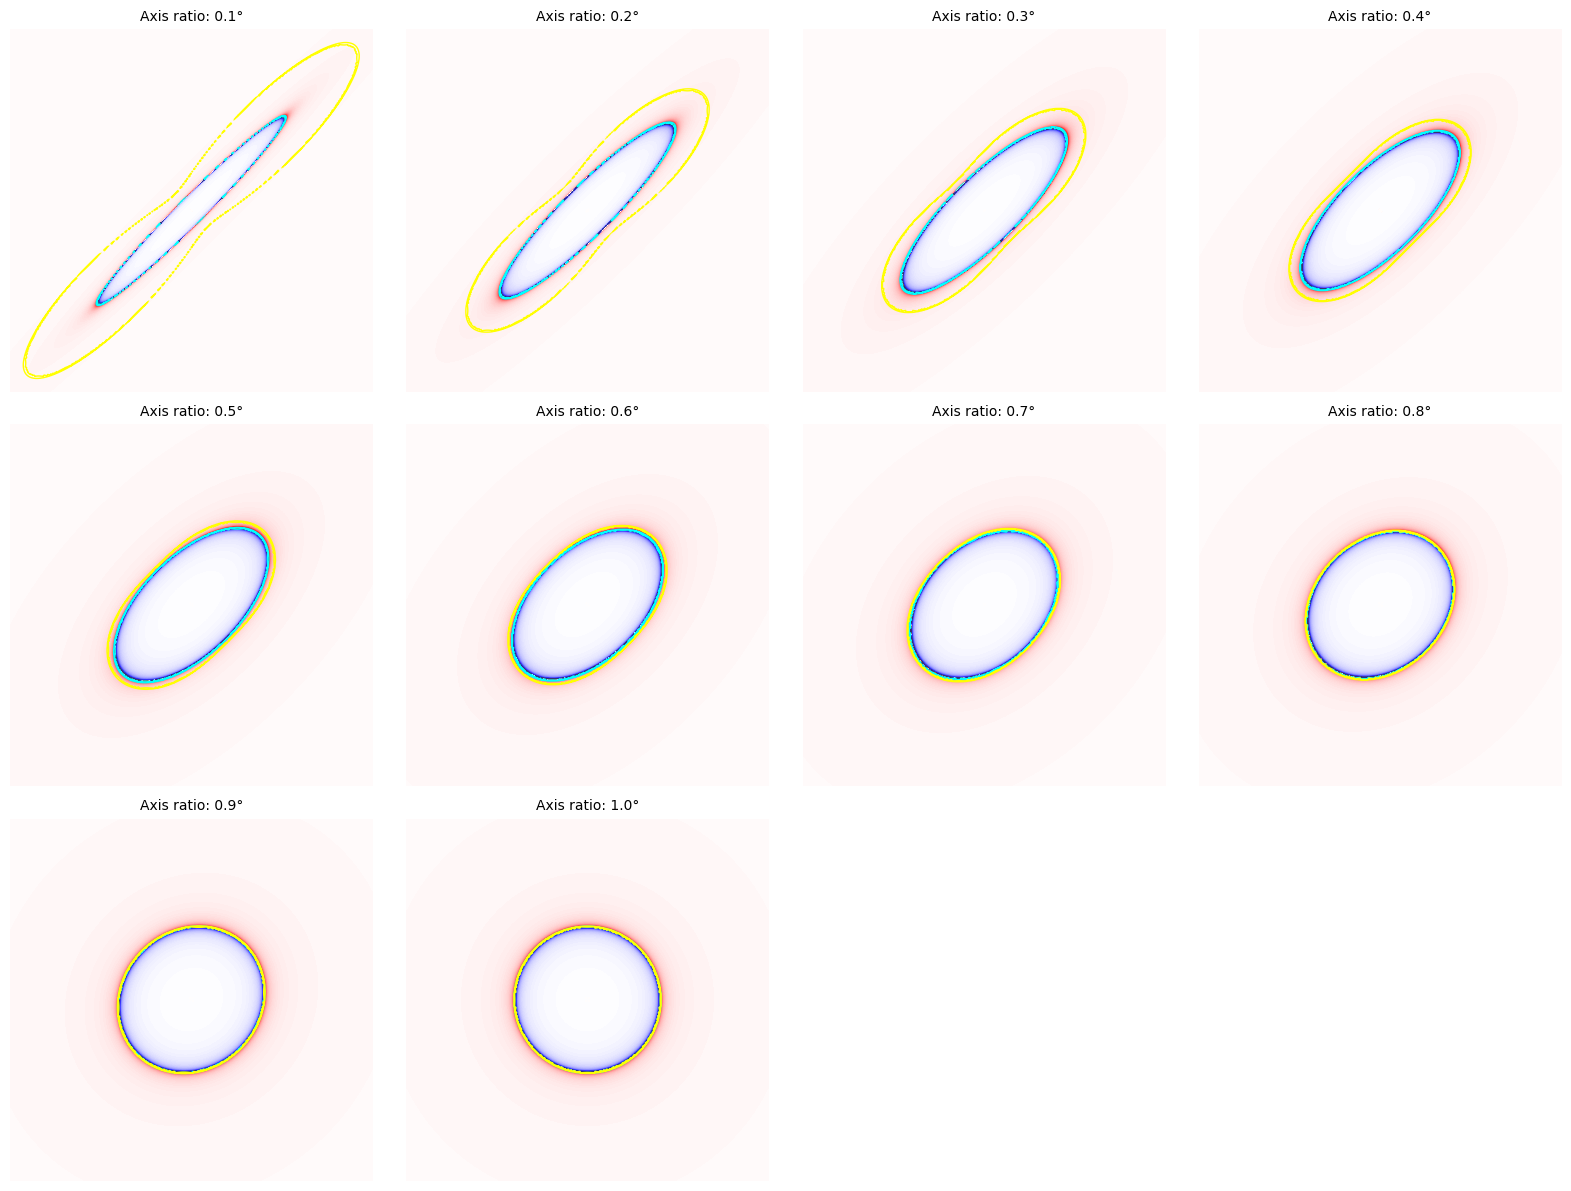

In [10]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45
arr = np.array([80])

grid_bigger = al.Grid2D.uniform(
    shape_native=(500, 500),
    pixel_scales=0.01,
)
xgrid = grid_bigger.native[:, :, 0]
ygrid = grid_bigger.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)


    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.0,rs=1e8, b0=1.0
    )
    mass_dpiep=dPIEP(
        centre=(0, 0), ell_comps=ell_comps,
        ra = 0.0, rs=1e8,
        b0=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

    mu_map_dpiemd = mass_dpiemd.magnification_2d_from(grid=grid_bigger).native
    mu_map_dpiep = mass_dpiep.magnification_2d_from(grid=grid_bigger).native
    model_image_test = bulge.image_2d_from(grid=grid_bigger).native


    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    contours_0 = ax.contour(
        ygrid, xgrid, mu_map_dpiemd, colors="cyan", levels=arr, linewidths=1.0
    )
    contours_1 = ax.contour(
        ygrid, xgrid, mu_map_dpiep, colors="yellow", levels=arr, linewidths=1.0
    )

    # ax.clabel(contours_0, inline=True, fontsize=8)
    # ax.clabel(contours_1, inline=True, fontsize=8)


    ax.set_title(f"Axis ratio: {axis_ratio}°", fontsize=10)
    ax.imshow(
        mu_map_dpiemd, norm="linear", cmap="seismic", extent=ext, alpha=0.8, vmax=100, vmin=-100
    )
    ax.axis("off") 

for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

## 2 Comparison between dPIEMD with SIE
> when core radius -> 0, and truncation radius -> $\infty$, PIEMD and dPIEMD should be the same with Isothermal

The test results here demonstrate that the dPIEMD can degenerate into the Isothermal profile under extreme conditions.

### 2.1 Test deflection angle

#### 2.1.1 Vector Field

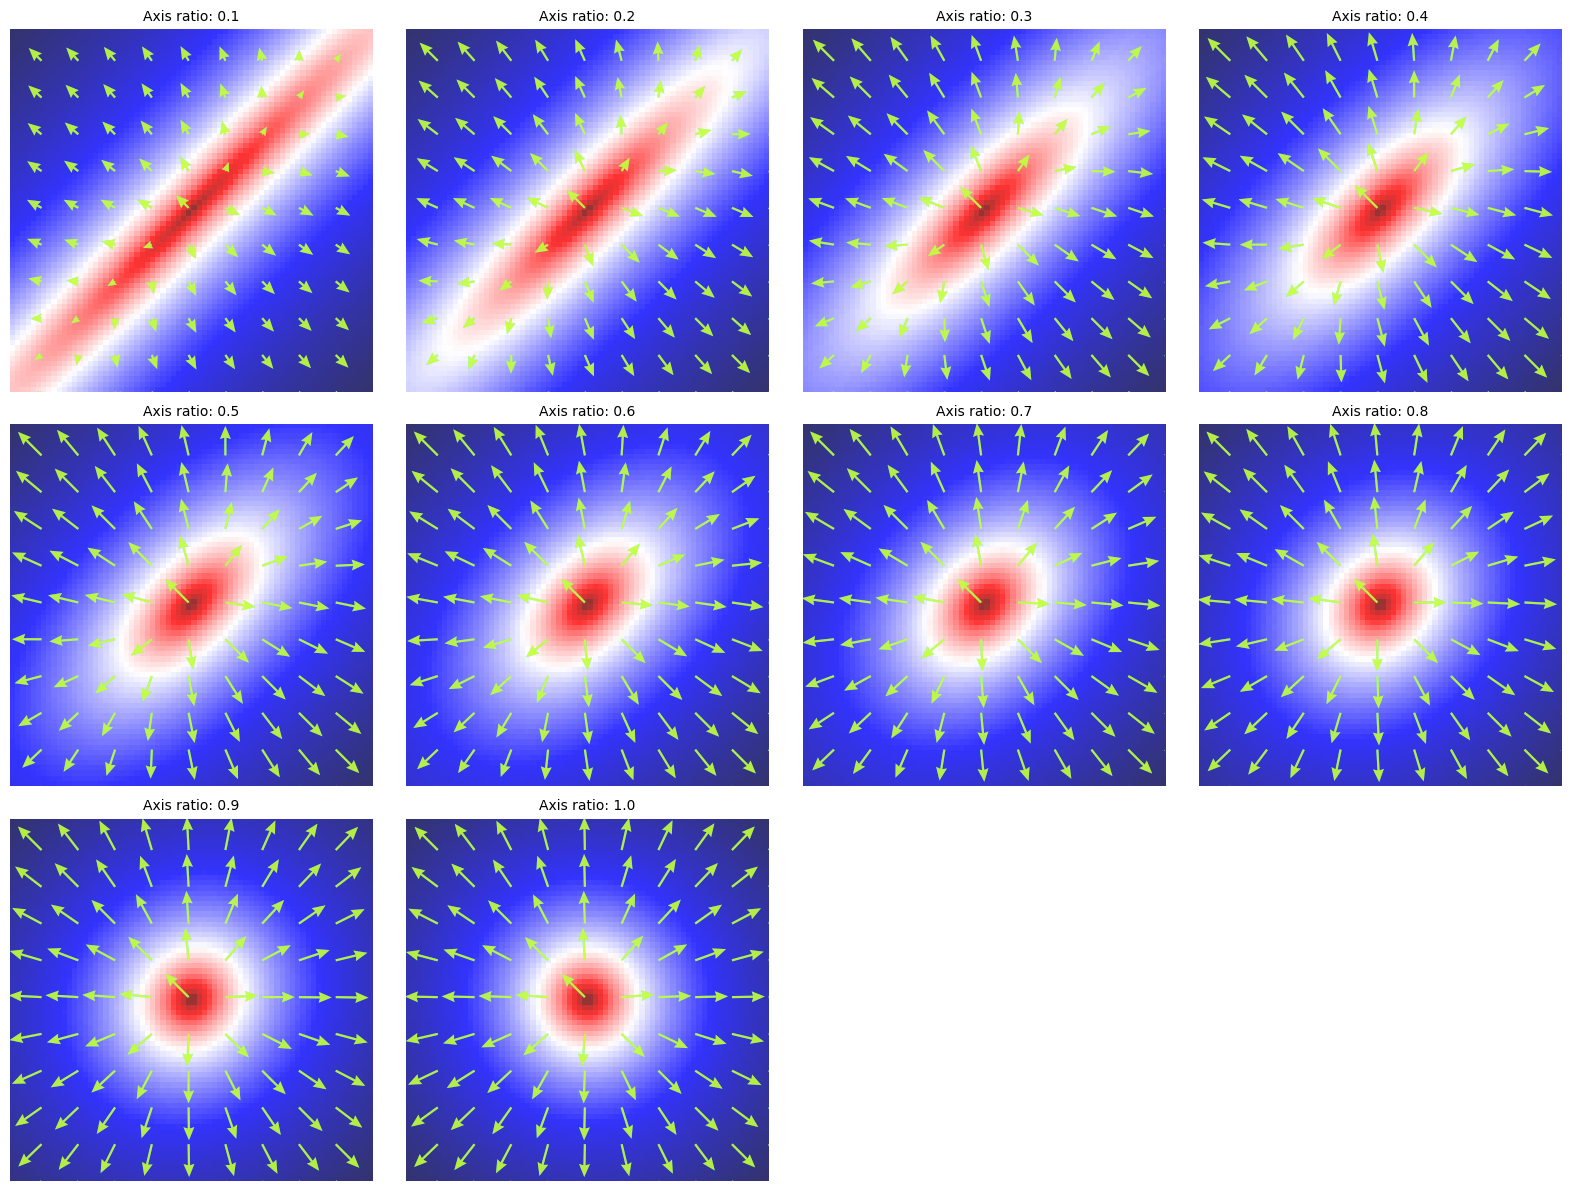

In [11]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

sampling_step = 7
x_sample = xgrid[::sampling_step, ::sampling_step]
y_sample = ygrid[::sampling_step, ::sampling_step]
arrow_scale = 0.25
head_width = 5
head_length = 6

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)

    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.0,rs=1e8, b0=1.0
    )
    mass_sie=al.mp.Isothermal(
        centre=(0, 0), ell_comps=ell_comps,
        einstein_radius=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

    deflections_dpiemd = mass_dpiemd.deflections_yx_2d_from(grid=grid).native
    deflections_sie = mass_sie.deflections_yx_2d_from(grid=grid).native
    model_image_test = bulge.image_2d_from(grid=grid).native

    deflections_x_dpiemd = deflections_dpiemd[::sampling_step, ::sampling_step, 0]
    deflections_y_dpiemd = deflections_dpiemd[::sampling_step, ::sampling_step, 1]

    deflections_x_sie = deflections_sie[::sampling_step, ::sampling_step, 0]
    deflections_y_sie = deflections_sie[::sampling_step, ::sampling_step, 1]

    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    ax.quiver(
        x_sample, y_sample, deflections_x_dpiemd, deflections_y_dpiemd,
        color="cyan",
        scale=1 / arrow_scale,
        scale_units="xy",
        headwidth=head_width,
        headlength=head_length,
        headaxislength=head_length * 0.9,
        alpha=0.7
    )

    ax.quiver(
        x_sample, y_sample, deflections_x_sie, deflections_y_sie,
        color="yellow",
        scale=1 / arrow_scale,
        scale_units="xy",
        headwidth=head_width,
        headlength=head_length,
        headaxislength=head_length * 0.9,
        alpha=0.7
    )

    ax.imshow(
        model_image_test, norm="log", cmap="seismic", extent=ext, alpha=0.8
    )

    ax.set_title(f"Axis ratio: {axis_ratio}", fontsize=10)

    ax.axis("off")
for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()


#### 2.1.2 Residual(X)

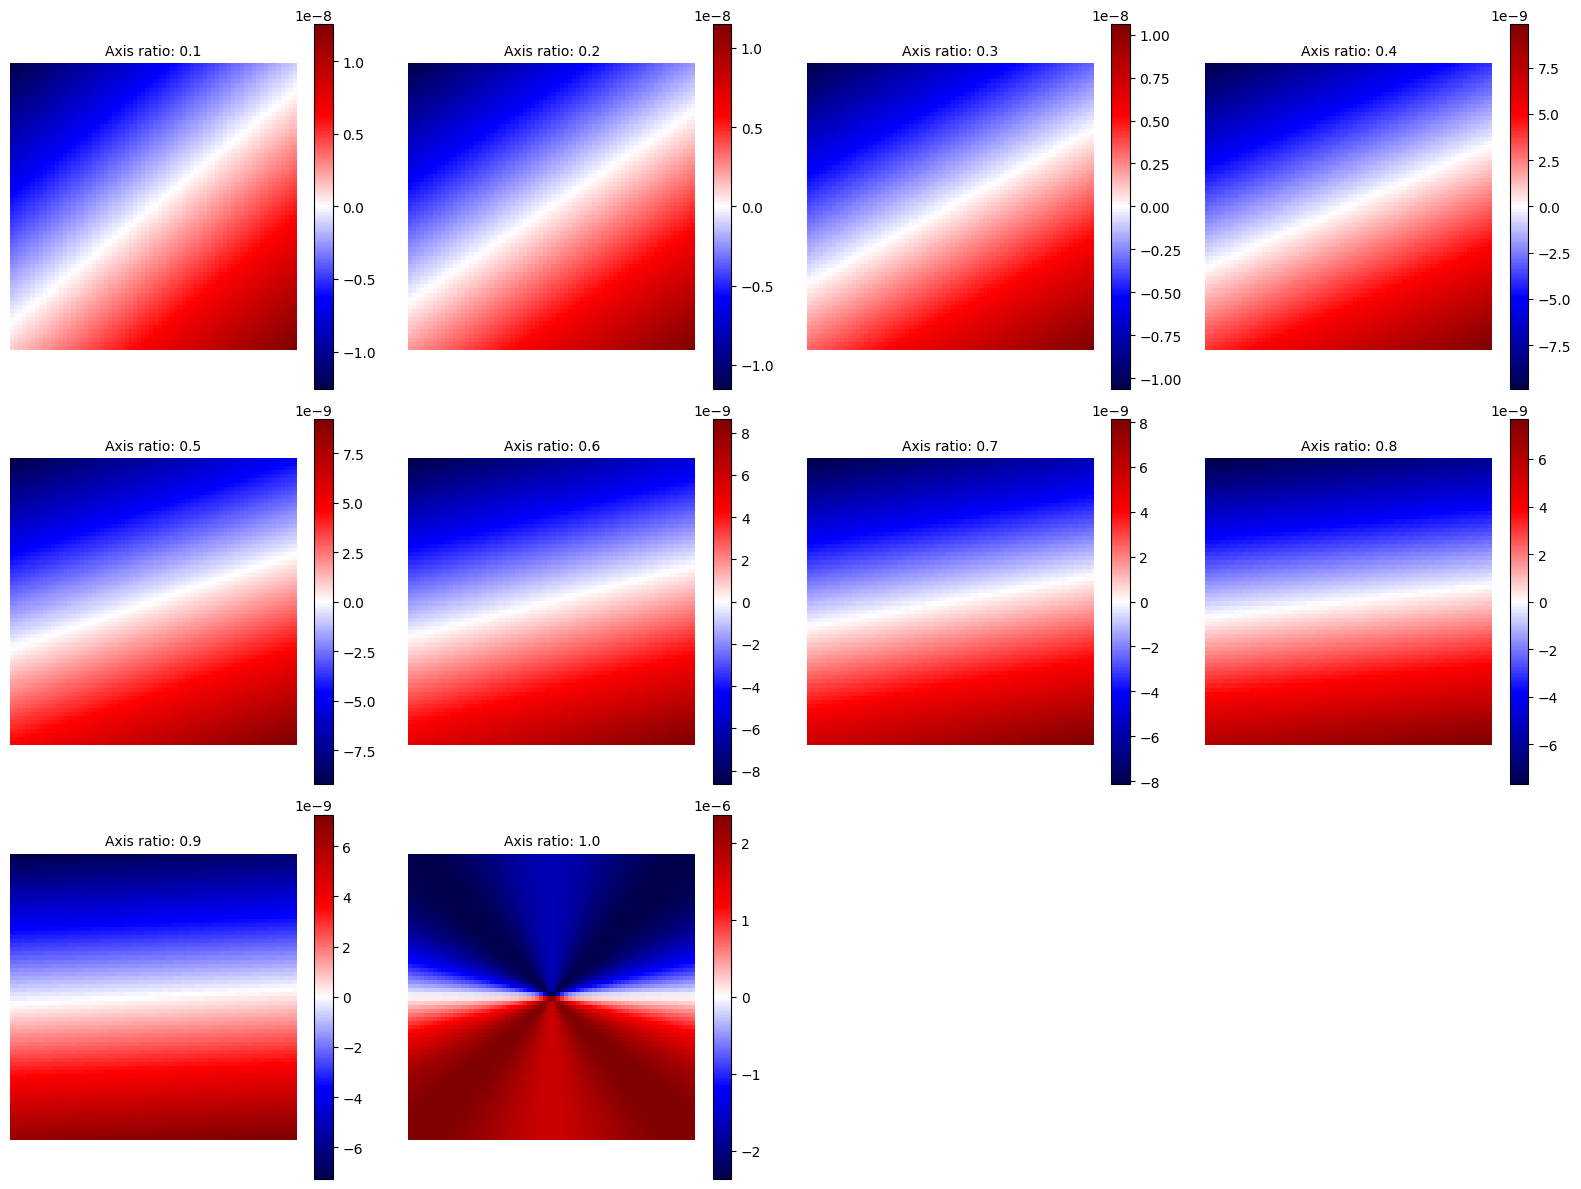

In [12]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

sampling_step = 7
x_sample = xgrid[::sampling_step, ::sampling_step]
y_sample = ygrid[::sampling_step, ::sampling_step]
arrow_scale = 0.25
head_width = 5
head_length = 6

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)

    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.0,rs=1e8, b0=1.0
    )
    mass_sie=al.mp.Isothermal(
        centre=(0, 0), ell_comps=ell_comps,
        einstein_radius=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

    deflections_dpiemd = mass_dpiemd.deflections_yx_2d_from(grid=grid).native
    deflections_sie = mass_sie.deflections_yx_2d_from(grid=grid).native
    model_image_test = bulge.image_2d_from(grid=grid).native

    deflections_x_dpiemd = deflections_dpiemd[:,:, 0]
    deflections_y_dpiemd = deflections_dpiemd[:,:, 1]

    deflections_x_sie = deflections_sie[:,:, 0]
    deflections_y_sie = deflections_sie[:,:, 1]



    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    # img = ax.imshow(
    #     deflections_x_dpiemd - deflections_x_sie, norm="linear", cmap="seismic", extent=ext,
    # )
    img = ax.imshow(
        deflections_x_dpiemd - deflections_x_sie, norm="linear", cmap="seismic", extent=ext,
    )

    ax.set_title(f"Axis ratio: {axis_ratio}", fontsize=10)
    fig.colorbar(img, ax=ax)

    ax.axis("off")
for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()


#### 2.1.3 Residual(Y)

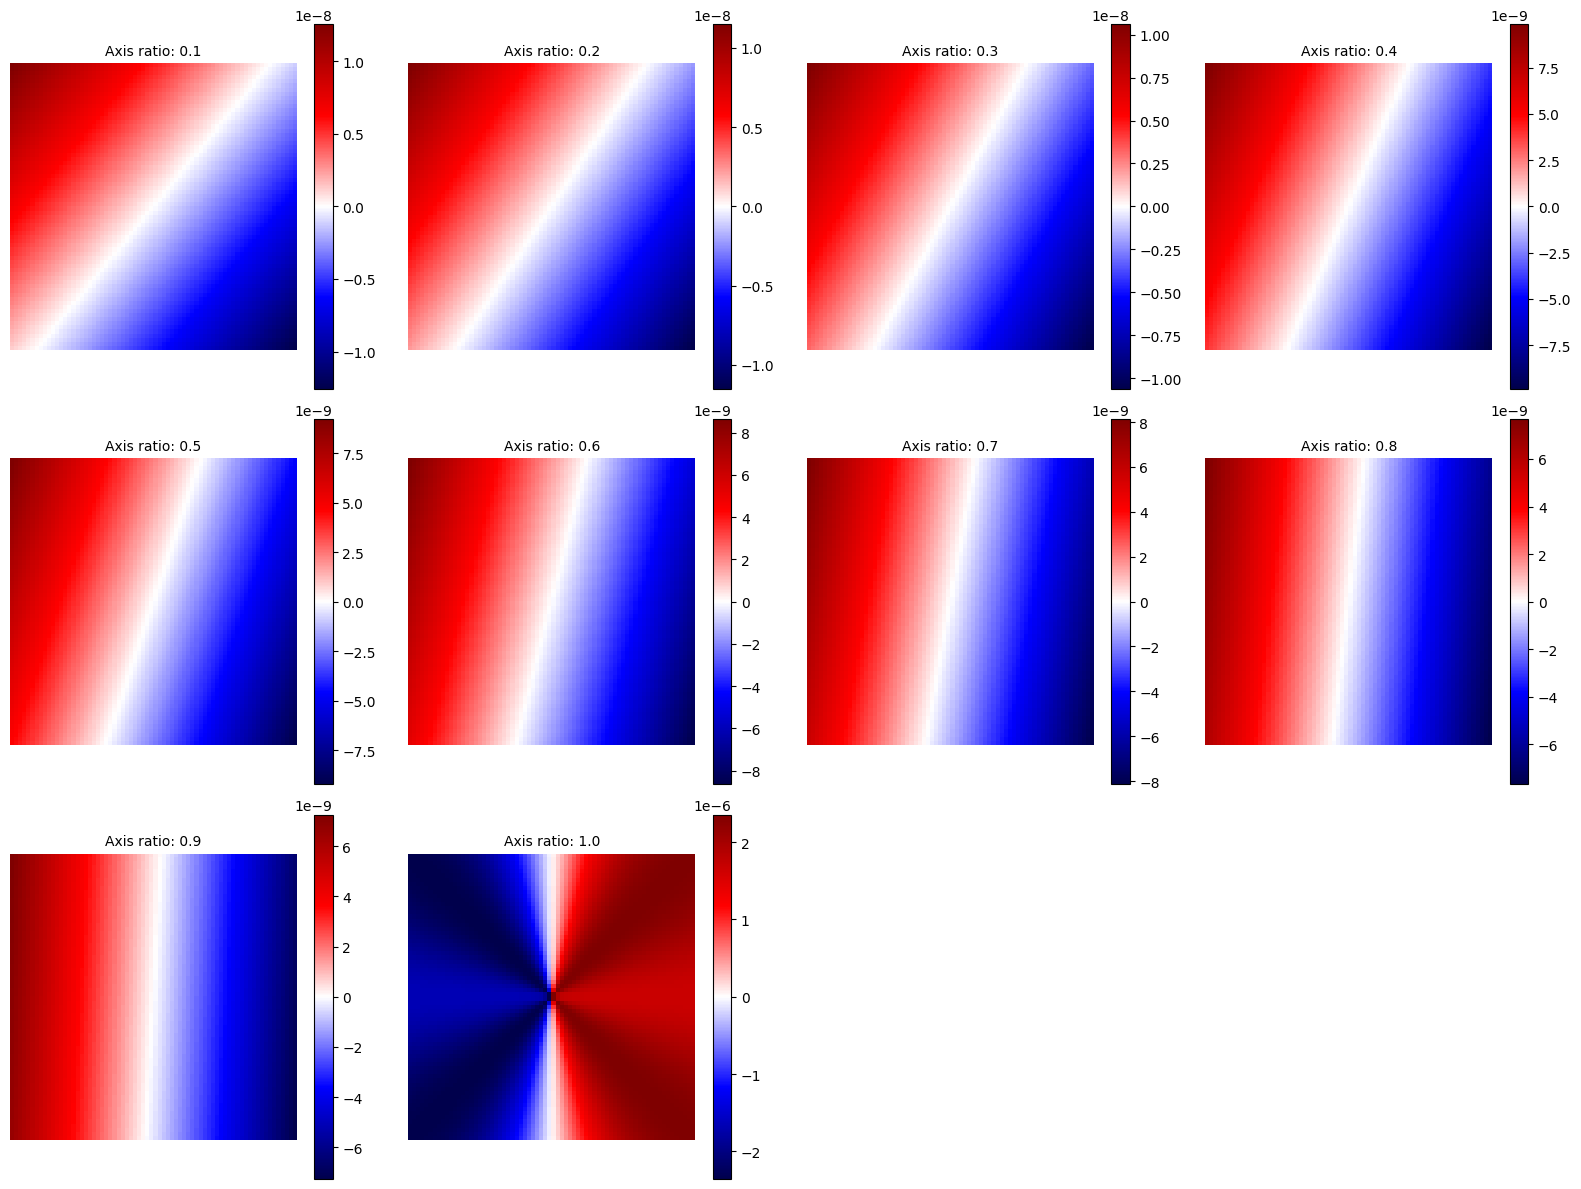

In [13]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

sampling_step = 7
x_sample = xgrid[::sampling_step, ::sampling_step]
y_sample = ygrid[::sampling_step, ::sampling_step]
arrow_scale = 0.25
head_width = 5
head_length = 6

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)

    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.0,rs=1e8, b0=1.0
    )
    mass_sie=al.mp.Isothermal(
        centre=(0, 0), ell_comps=ell_comps,
        einstein_radius=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

    deflections_dpiemd = mass_dpiemd.deflections_yx_2d_from(grid=grid).native
    deflections_sie = mass_sie.deflections_yx_2d_from(grid=grid).native
    model_image_test = bulge.image_2d_from(grid=grid).native

    deflections_x_dpiemd = deflections_dpiemd[:,:, 0]
    deflections_y_dpiemd = deflections_dpiemd[:,:, 1]

    deflections_x_sie = deflections_sie[:,:, 0]
    deflections_y_sie = deflections_sie[:,:, 1]



    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    # img = ax.imshow(
    #     deflections_x_dpiemd - deflections_x_sie, norm="linear", cmap="seismic", extent=ext,
    # )
    img = ax.imshow(
        deflections_y_dpiemd - deflections_y_sie, norm="linear", cmap="seismic", extent=ext,
    )

    ax.set_title(f"Axis ratio: {axis_ratio}", fontsize=10)
    fig.colorbar(img, ax=ax)

    ax.axis("off")
for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()


### 2.2 Test $\kappa$ map

#### 2.2.1 Contours

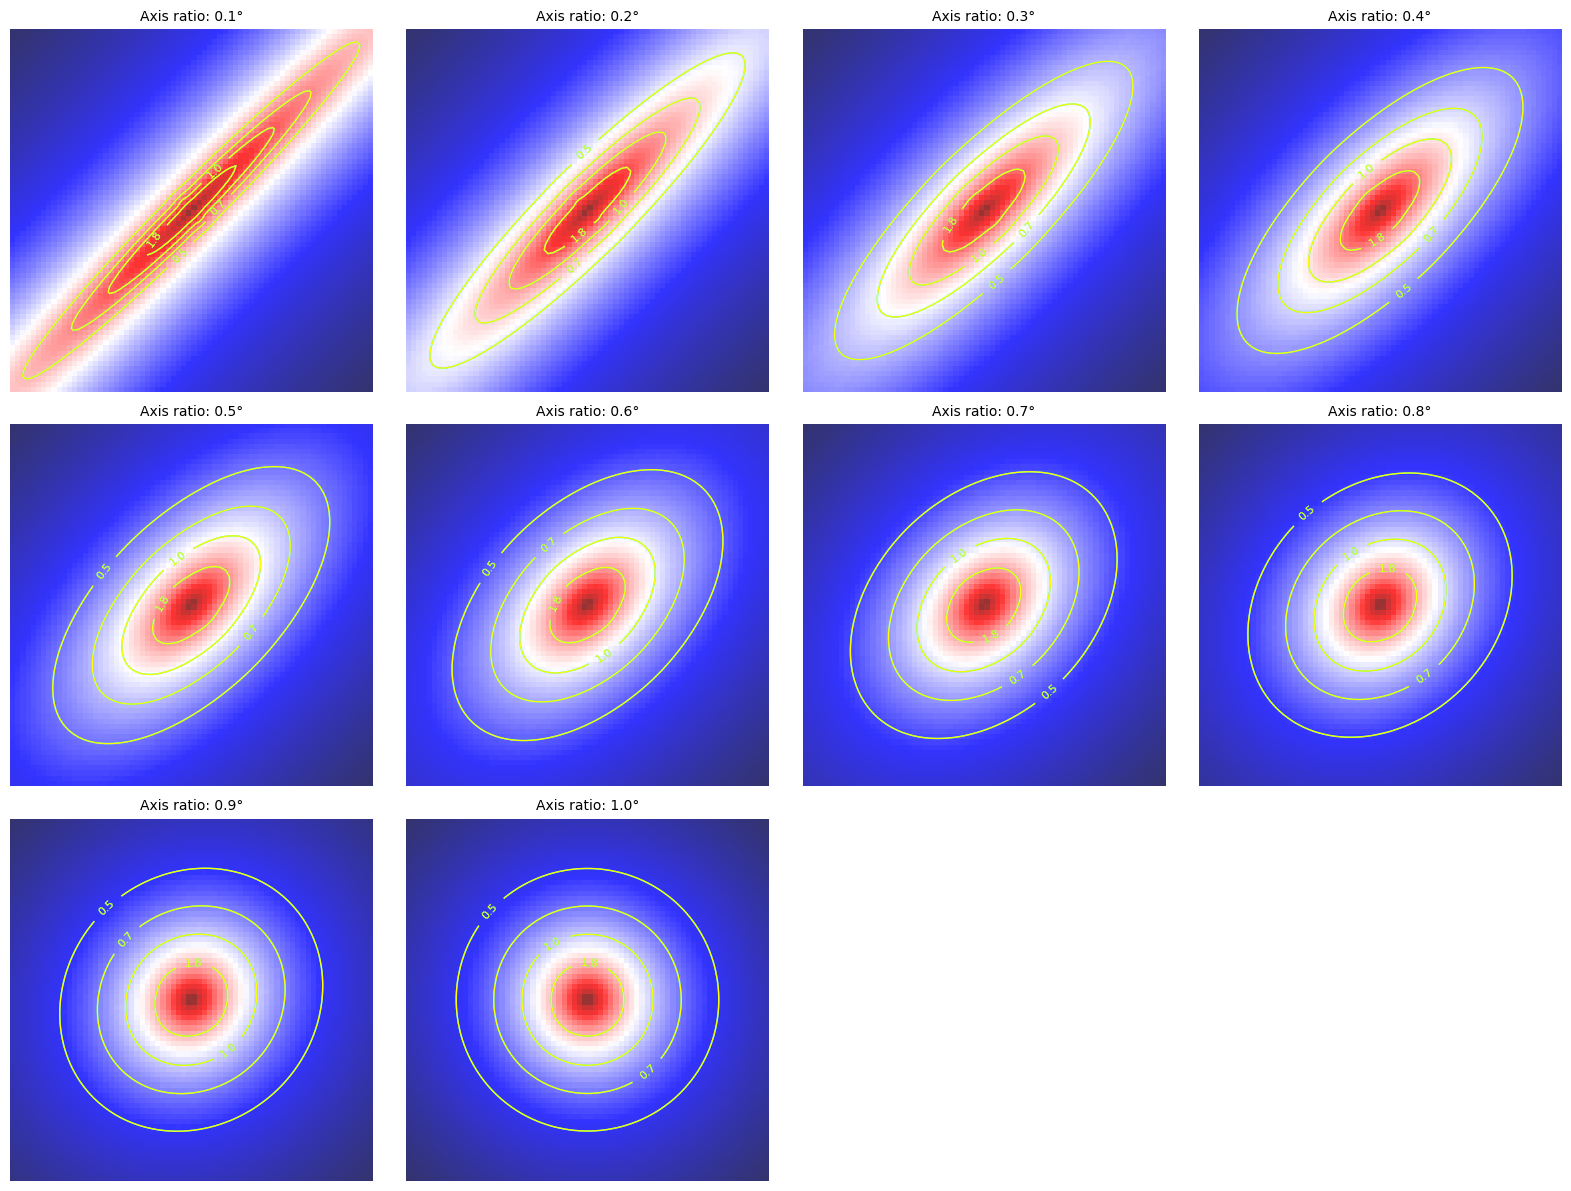

In [14]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45
arr = np.array([0.5,0.7,1.0, 1.8])

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)


    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.0,rs=1e8, b0=1.0
    )
    mass_sie=al.mp.Isothermal(
        centre=(0, 0), ell_comps=ell_comps,
        einstein_radius=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

    kappa_map_dpiemd = mass_dpiemd.convergence_2d_via_jacobian_from(grid=grid).native
    kappa_map_sie = mass_sie.convergence_2d_via_jacobian_from(grid=grid).native
    model_image_test = bulge.image_2d_from(grid=grid).native


    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    contours_0 = ax.contour(
        ygrid, xgrid, kappa_map_dpiemd, colors="cyan", levels=arr, linewidths=1.0
    )
    contours_1 = ax.contour(
        ygrid, xgrid, kappa_map_sie, colors="yellow", levels=arr, linewidths=1.0
    )

    ax.clabel(contours_0, inline=True, fontsize=8)
    ax.clabel(contours_1, inline=True, fontsize=8)


    ax.set_title(f"Axis ratio: {axis_ratio}°", fontsize=10)
    ax.imshow(
        model_image_test, norm="log", cmap="seismic", extent=ext, alpha=0.8
    )
    ax.axis("off") 

for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

#### 2.2.2 Residaul

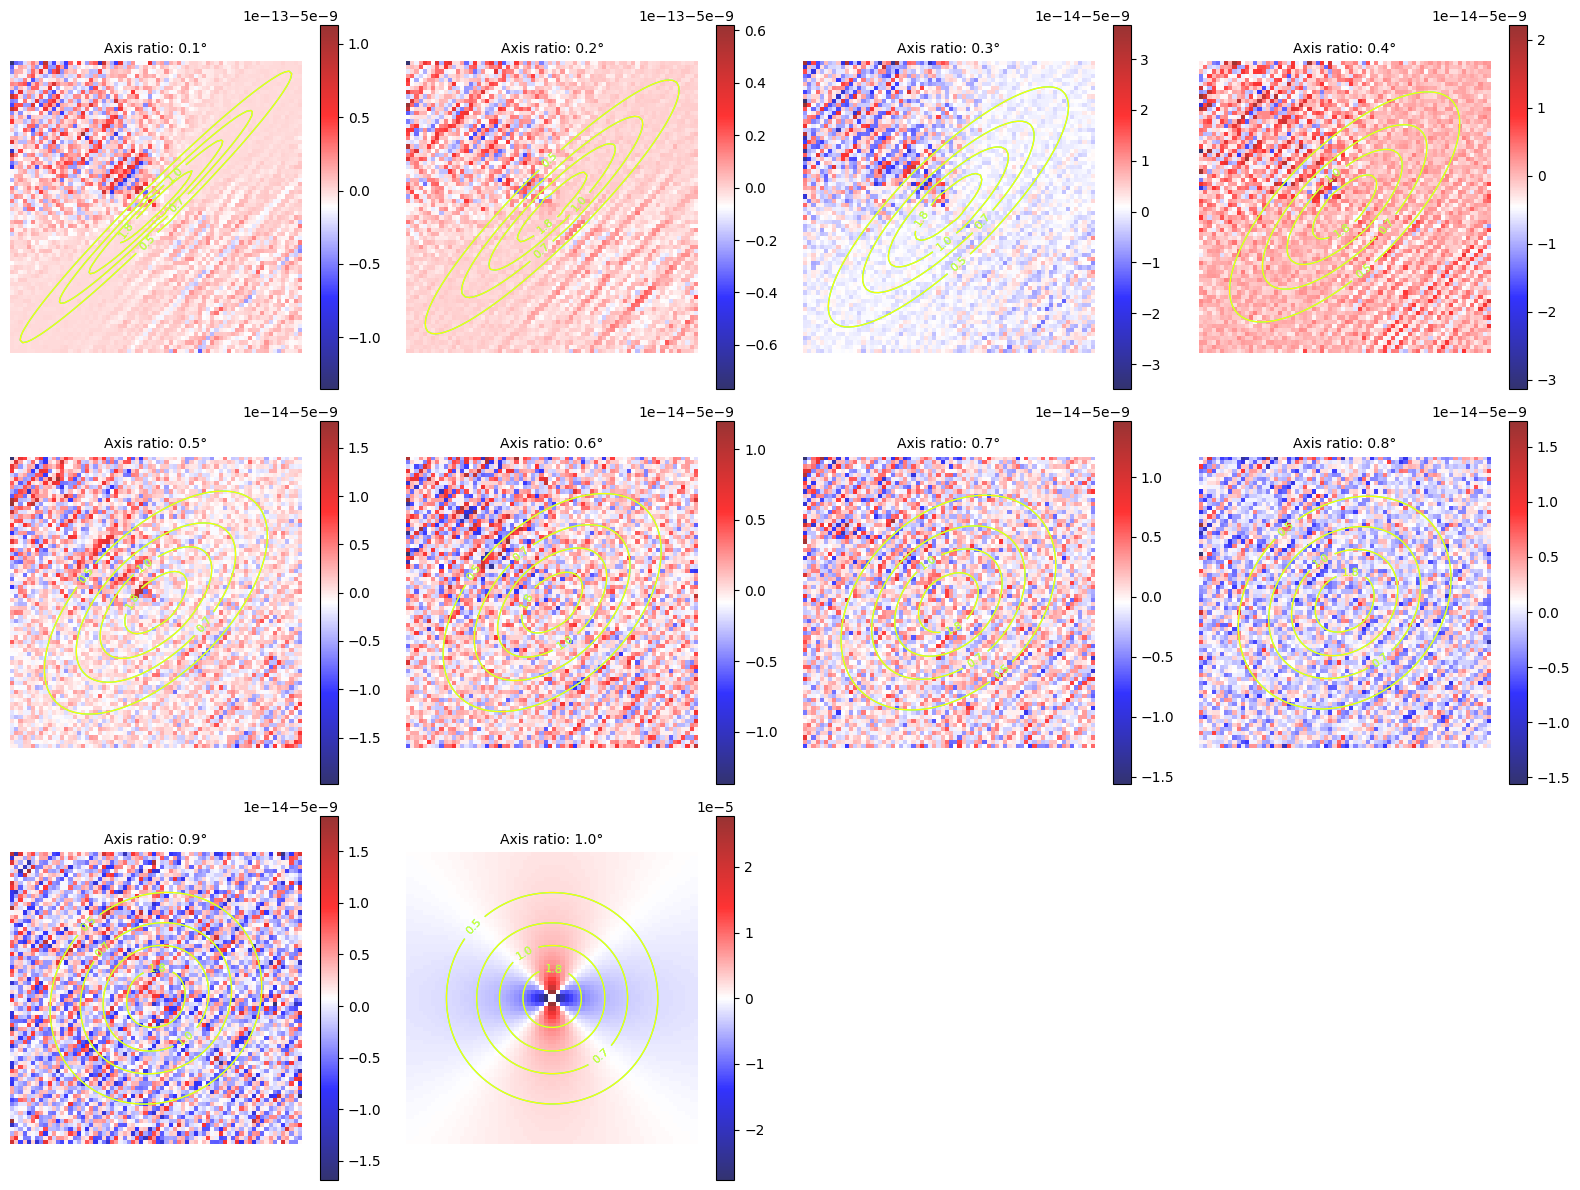

In [15]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45
arr = np.array([0.5,0.7,1.0, 1.8])

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)


    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.0,rs=1e8, b0=1.0
    )
    mass_sie=al.mp.Isothermal(
        centre=(0, 0), ell_comps=ell_comps,
        einstein_radius=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

    kappa_map_dpiemd = mass_dpiemd.convergence_2d_via_jacobian_from(grid=grid).native
    kappa_map_sie = mass_sie.convergence_2d_via_jacobian_from(grid=grid).native
    model_image_test = bulge.image_2d_from(grid=grid).native


    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    contours_0 = ax.contour(
        ygrid, xgrid, kappa_map_dpiemd, colors="cyan", levels=arr, linewidths=1.0
    )
    contours_1 = ax.contour(
        ygrid, xgrid, kappa_map_sie, colors="yellow", levels=arr, linewidths=1.0
    )

    ax.clabel(contours_0, inline=True, fontsize=8)
    ax.clabel(contours_1, inline=True, fontsize=8)


    ax.set_title(f"Axis ratio: {axis_ratio}°", fontsize=10)
    img = ax.imshow(
        kappa_map_dpiemd - kappa_map_sie, norm="linear", cmap="seismic", extent=ext, alpha=0.8
    )
    ax.axis("off") 
    fig.colorbar(img, ax=ax)

for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

### 2.3 Test lensed image

#### 2.3.1 Contours

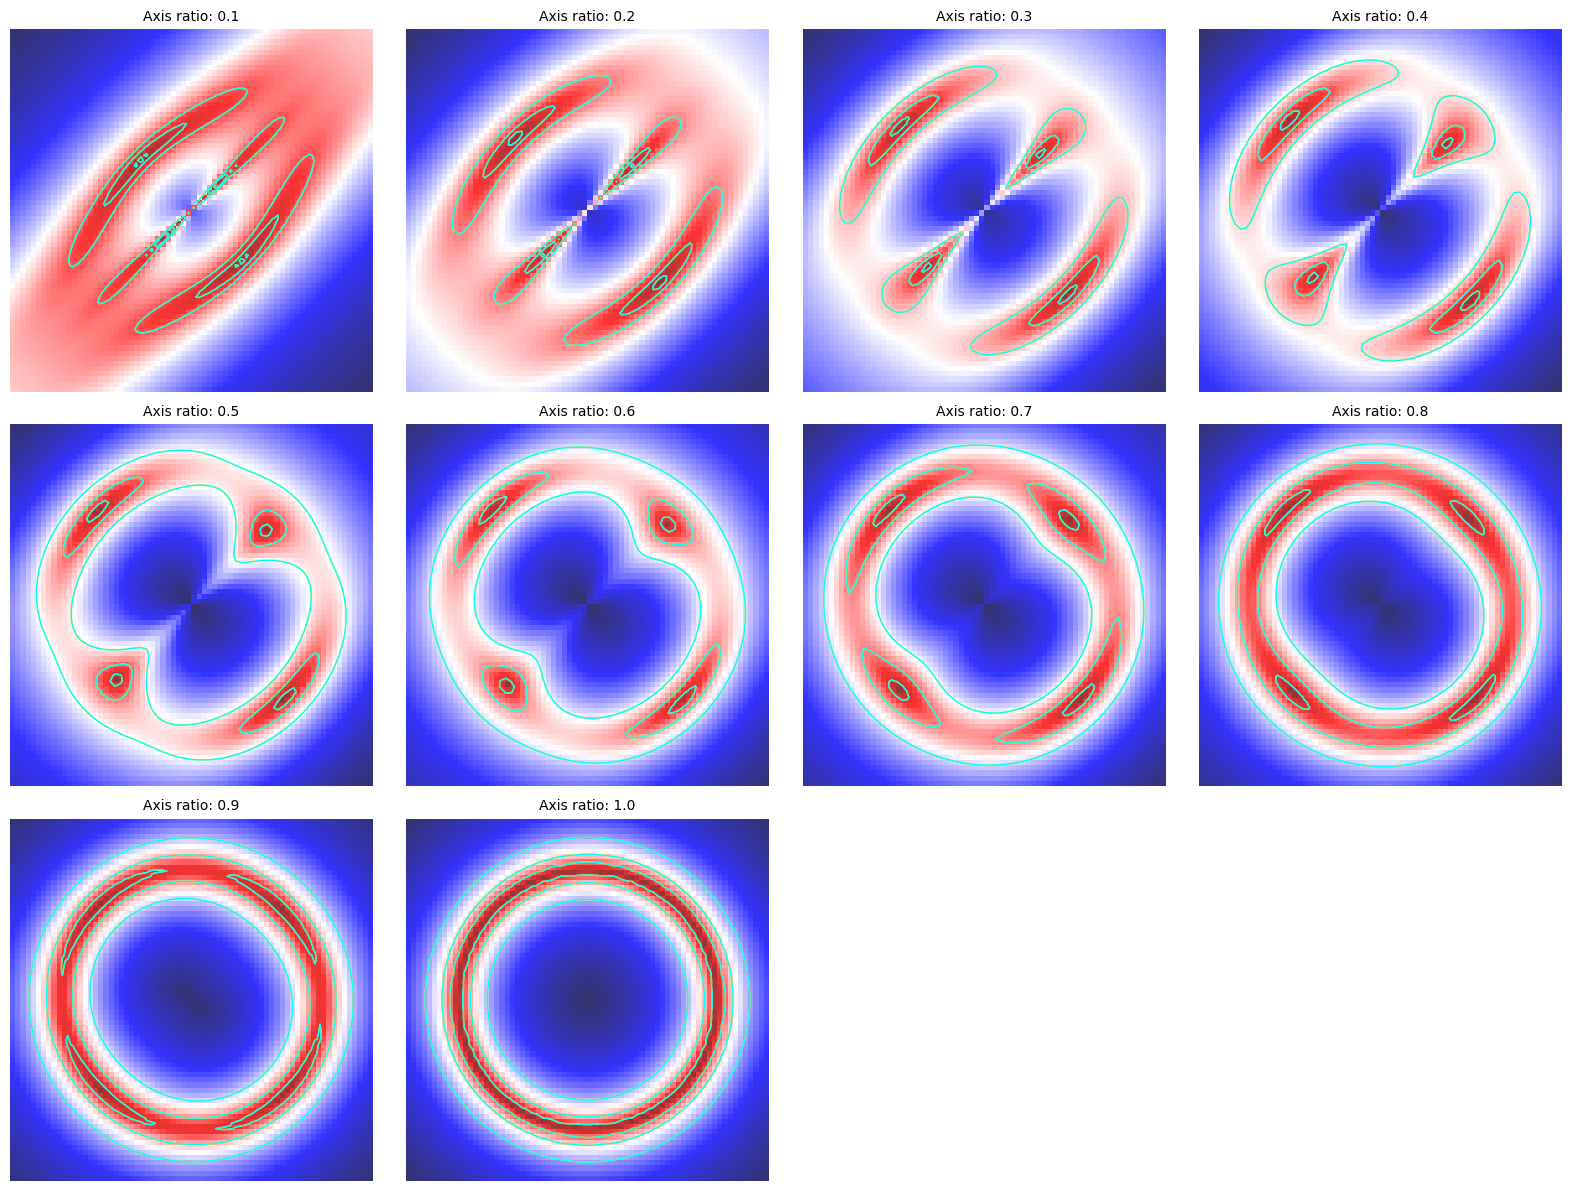

In [16]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45
# arr = np.array([1.0, 1.8])

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)

fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

for i, q in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=q, angle=angle)

    tracer_temp_dpiemd = al.Tracer(
        galaxies=af.Collection(
            lens=al.Galaxy(
                redshift=0.5,
                mass_dpie=dPIEMD(
                    centre=(0, 0), ell_comps=ell_comps,
                    ra=0.0, rs=1e8, b0=1.0
                ),
            ),
            source=al.Galaxy(
                redshift=1.0,
                bulge = al.lp.Sersic(centre=(0,0),ell_comps=ell_comps)
            )
        )
    )
    tracer_temp_sie = al.Tracer(
        galaxies=af.Collection(
            lens=al.Galaxy(
                redshift=0.5,
                mass_sie=al.mp.Isothermal(
                    centre=(0, 0), ell_comps=ell_comps,
                    einstein_radius=1.0
                ),
            ),
            source=al.Galaxy(
                redshift=1.0,
                bulge = al.lp.Sersic(centre=(0,0),ell_comps=ell_comps)
            )
        )
    )
    
    model_arc_test_dpiemd = tracer_temp_dpiemd.image_2d_from(grid=grid).native
    model_arc_test_sie = tracer_temp_sie.image_2d_from(grid=grid).native

 
    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]
    img = ax.imshow(
        model_arc_test_dpiemd, norm="log", cmap="seismic", extent=ext, alpha=0.8
    )
    arr = np.array([0.5,1.5,5.0])
    contours_sie = ax.contour(
        ygrid, xgrid, model_arc_test_sie, colors="yellow", levels=arr, linewidths=1.0
    )
    contours_dpie = ax.contour(
        ygrid, xgrid, model_arc_test_dpiemd, colors="cyan", levels=arr, linewidths=1.0
    )


    ax.set_title(f"Axis ratio: {q}", fontsize=10)

    ax.axis("off")

for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

#### 2.3.2 Residual

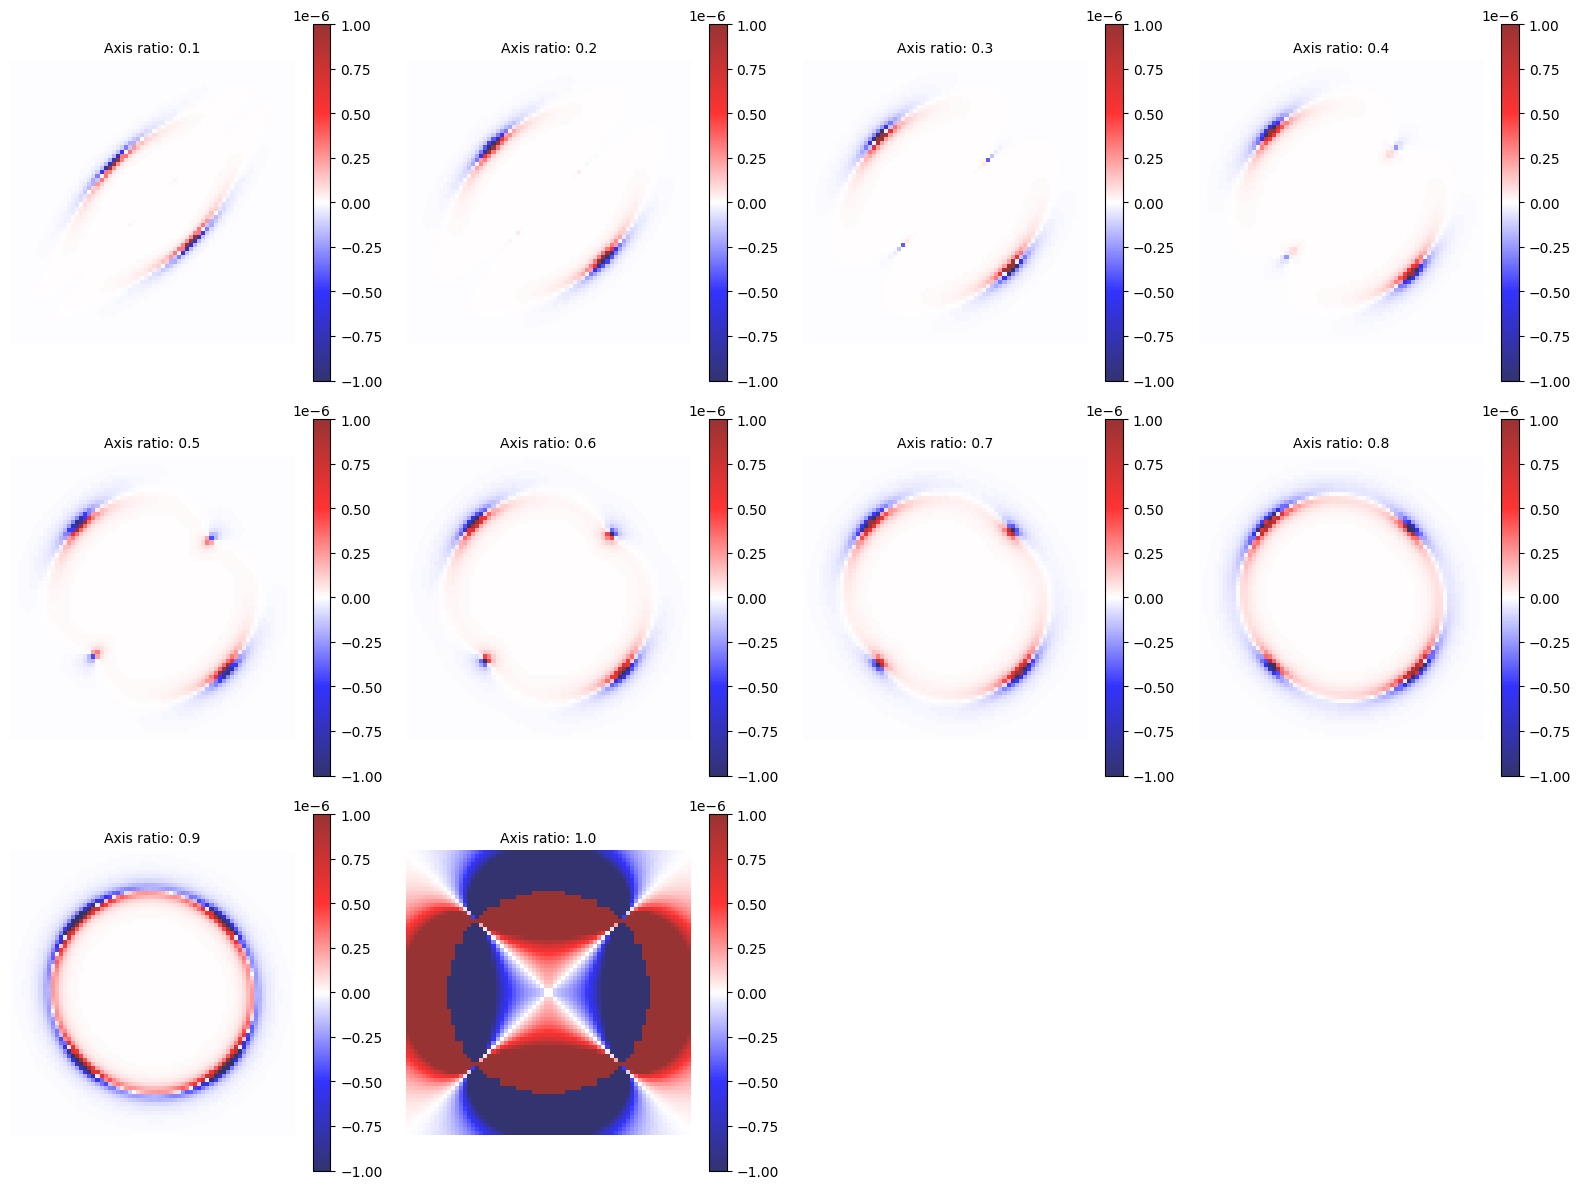

In [17]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45
# arr = np.array([1.0, 1.8])

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)

fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

for i, q in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=q, angle=angle)

    tracer_temp_dpiemd = al.Tracer(
        galaxies=af.Collection(
            lens=al.Galaxy(
                redshift=0.5,
                mass_dpie=dPIEMD(
                    centre=(0, 0), ell_comps=ell_comps,
                    ra=0.0, rs=1e8, b0=1.0
                ),
            ),
            source=al.Galaxy(
                redshift=1.0,
                bulge = al.lp.Sersic(centre=(0,0),ell_comps=ell_comps)
            )
        )
    )
    tracer_temp_sie = al.Tracer(
        galaxies=af.Collection(
            lens=al.Galaxy(
                redshift=0.5,
                mass_sie=al.mp.Isothermal(
                    centre=(0, 0), ell_comps=ell_comps,
                    einstein_radius=1.0
                ),
            ),
            source=al.Galaxy(
                redshift=1.0,
                bulge = al.lp.Sersic(centre=(0,0),ell_comps=ell_comps)
            )
        )
    )
    
    model_arc_test_dpiemd = tracer_temp_dpiemd.image_2d_from(grid=grid).native
    model_arc_test_sie = tracer_temp_sie.image_2d_from(grid=grid).native

 
    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]
    img = ax.imshow(
        model_arc_test_dpiemd - model_arc_test_sie, norm="linear", cmap="seismic", extent=ext, alpha=0.8,vmax=1e-6,vmin=-1e-6
    )
    # arr = np.array([0.5,1.5,5.0])
    # contours_sie = ax.contour(
    #     ygrid, xgrid, model_arc_test_sie, colors="yellow", levels=arr, linewidths=1.0
    # )
    # contours_dpie = ax.contour(
    #     ygrid, xgrid, model_arc_test_dpiemd, colors="cyan", levels=arr, linewidths=1.0
    # )


    ax.set_title(f"Axis ratio: {q}", fontsize=10)
    fig.colorbar(img, ax=ax)

    ax.axis("off")

for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

### 2.4 Test magnification map

#### 2.4.1 Contours

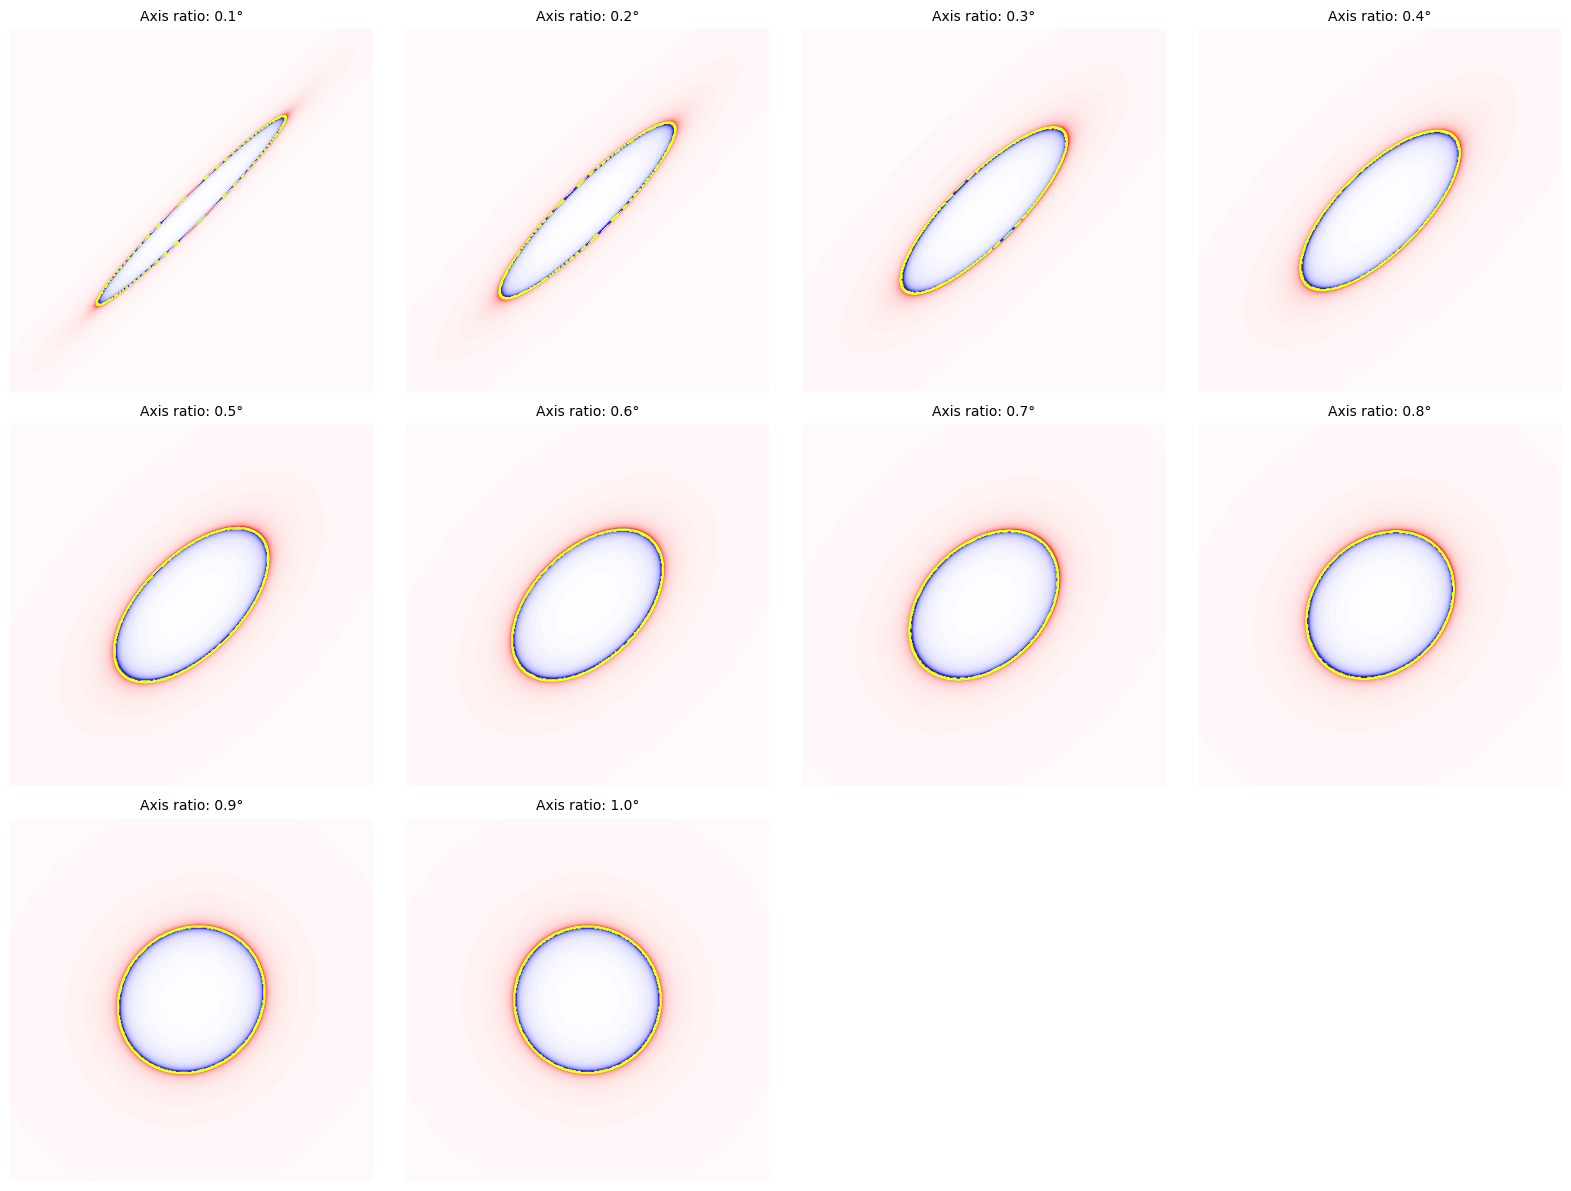

In [18]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45
arr = np.array([80])

grid_bigger = al.Grid2D.uniform(
    shape_native=(500, 500),
    pixel_scales=0.01,
)
xgrid = grid_bigger.native[:, :, 0]
ygrid = grid_bigger.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)

    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.0,rs=1e8, b0=1.0
    )
    mass_sie=al.mp.Isothermal(
        centre=(0, 0), ell_comps=ell_comps,
        einstein_radius=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)
    
    mu_map_dpiemd = mass_dpiemd.magnification_2d_from(grid=grid_bigger).native
    mu_map_sie = mass_sie.magnification_2d_from(grid=grid_bigger).native
    model_image_test = bulge.image_2d_from(grid=grid_bigger).native


    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    contours_0 = ax.contour(
        ygrid, xgrid, mu_map_dpiemd, colors="cyan", levels=arr, linewidths=1.0
    )
    contours_1 = ax.contour(
        ygrid, xgrid, mu_map_sie, colors="yellow", levels=arr, linewidths=1.0
    )

    # ax.clabel(contours_0, inline=True, fontsize=8)
    # ax.clabel(contours_1, inline=True, fontsize=8)


    ax.set_title(f"Axis ratio: {axis_ratio}°", fontsize=10)
    ax.imshow(
        mu_map_dpiemd, norm="linear", cmap="seismic", extent=ext, alpha=0.8, vmax=100, vmin=-100
    )
    ax.axis("off") 

for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

#### 2.4.2 Residual

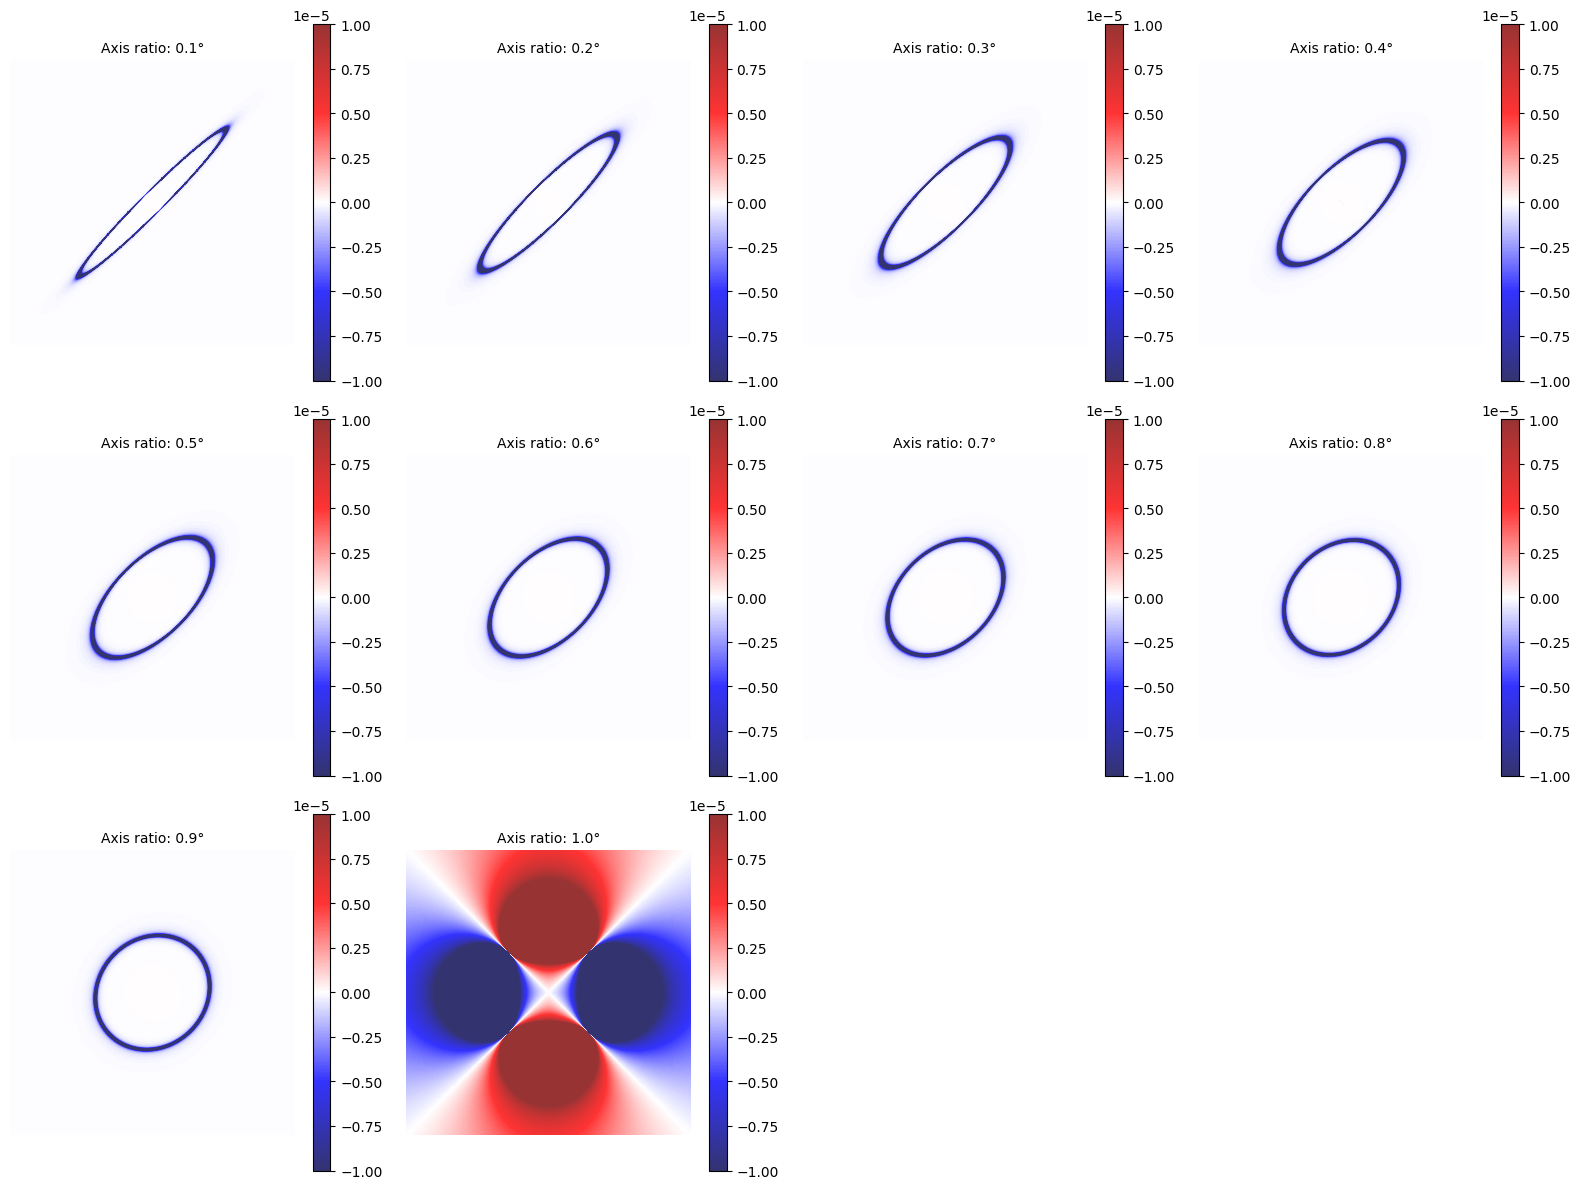

In [19]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45
arr = np.array([80])

grid_bigger = al.Grid2D.uniform(
    shape_native=(500, 500),
    pixel_scales=0.01,
)
xgrid = grid_bigger.native[:, :, 0]
ygrid = grid_bigger.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)

    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.0,rs=1e8, b0=1.0
    )
    mass_sie=al.mp.Isothermal(
        centre=(0, 0), ell_comps=ell_comps,
        einstein_radius=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)
    
    mu_map_dpiemd = mass_dpiemd.magnification_2d_from(grid=grid_bigger).native
    mu_map_sie = mass_sie.magnification_2d_from(grid=grid_bigger).native
    model_image_test = bulge.image_2d_from(grid=grid_bigger).native


    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    # contours_0 = ax.contour(
    #     ygrid, xgrid, mu_map_dpiemd, colors="cyan", levels=arr, linewidths=1.0
    # )
    # contours_1 = ax.contour(
    #     ygrid, xgrid, mu_map_sie, colors="yellow", levels=arr, linewidths=1.0
    # )

    # ax.clabel(contours_0, inline=True, fontsize=8)
    # ax.clabel(contours_1, inline=True, fontsize=8)


    ax.set_title(f"Axis ratio: {axis_ratio}°", fontsize=10)
    img = ax.imshow(
        mu_map_dpiemd - mu_map_sie, norm="linear", cmap="seismic", extent=ext, alpha=0.8, vmax=0.00001, vmin=-0.00001
    )
    fig.colorbar(img, ax=ax)
    ax.axis("off") 

for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

## 3 Comparison between PIEMD with dPIEMD
> when truncaton radius -> $\infty$, dPIEMD should be degenerate into PIEMD

### 3.1 Test deflection angle

#### 3.1.1 Vector Field

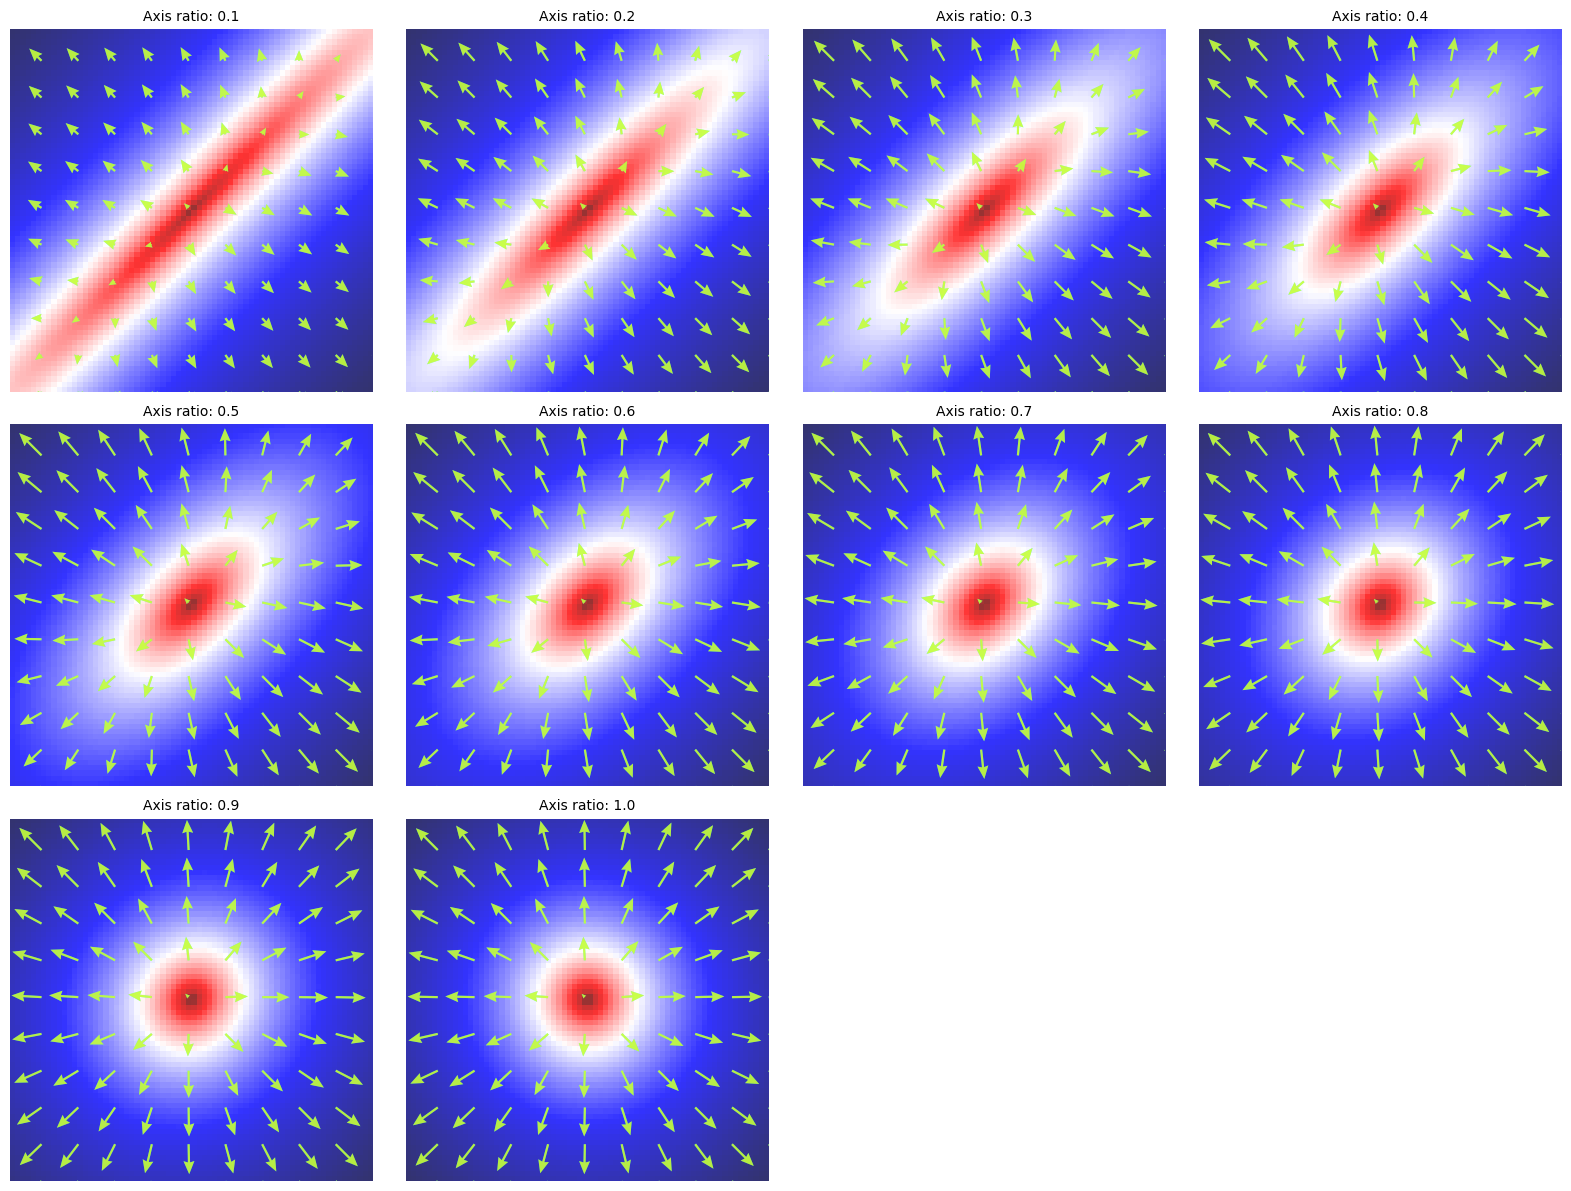

In [20]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

sampling_step = 7
x_sample = xgrid[::sampling_step, ::sampling_step]
y_sample = ygrid[::sampling_step, ::sampling_step]
arrow_scale = 0.25
head_width = 5
head_length = 6

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)

    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.1,rs=1e8, b0=1.0
    )
    mass_piemd=PIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.1,b0=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

    deflections_dpiemd = mass_dpiemd.deflections_yx_2d_from(grid=grid).native
    deflections_piemd = mass_piemd.deflections_yx_2d_from(grid=grid).native
    model_image_test = bulge.image_2d_from(grid=grid).native

    deflections_x_dpiemd = deflections_dpiemd[::sampling_step, ::sampling_step, 0]
    deflections_y_dpiemd = deflections_dpiemd[::sampling_step, ::sampling_step, 1]

    deflections_x_piemd = deflections_piemd[::sampling_step, ::sampling_step, 0]
    deflections_y_piemd = deflections_piemd[::sampling_step, ::sampling_step, 1]

    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    ax.quiver(
        x_sample, y_sample, deflections_x_dpiemd, deflections_y_dpiemd,
        color="cyan",
        scale=1 / arrow_scale,
        scale_units="xy",
        headwidth=head_width,
        headlength=head_length,
        headaxislength=head_length * 0.9,
        alpha=0.7
    )

    ax.quiver(
        x_sample, y_sample, deflections_x_piemd, deflections_y_piemd,
        color="yellow",
        scale=1 / arrow_scale,
        scale_units="xy",
        headwidth=head_width,
        headlength=head_length,
        headaxislength=head_length * 0.9,
        alpha=0.7
    )

    ax.imshow(
        model_image_test, norm="log", cmap="seismic", extent=ext, alpha=0.8
    )

    ax.set_title(f"Axis ratio: {axis_ratio}", fontsize=10)

    ax.axis("off")
for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()


#### 3.1.2 Residual(X)

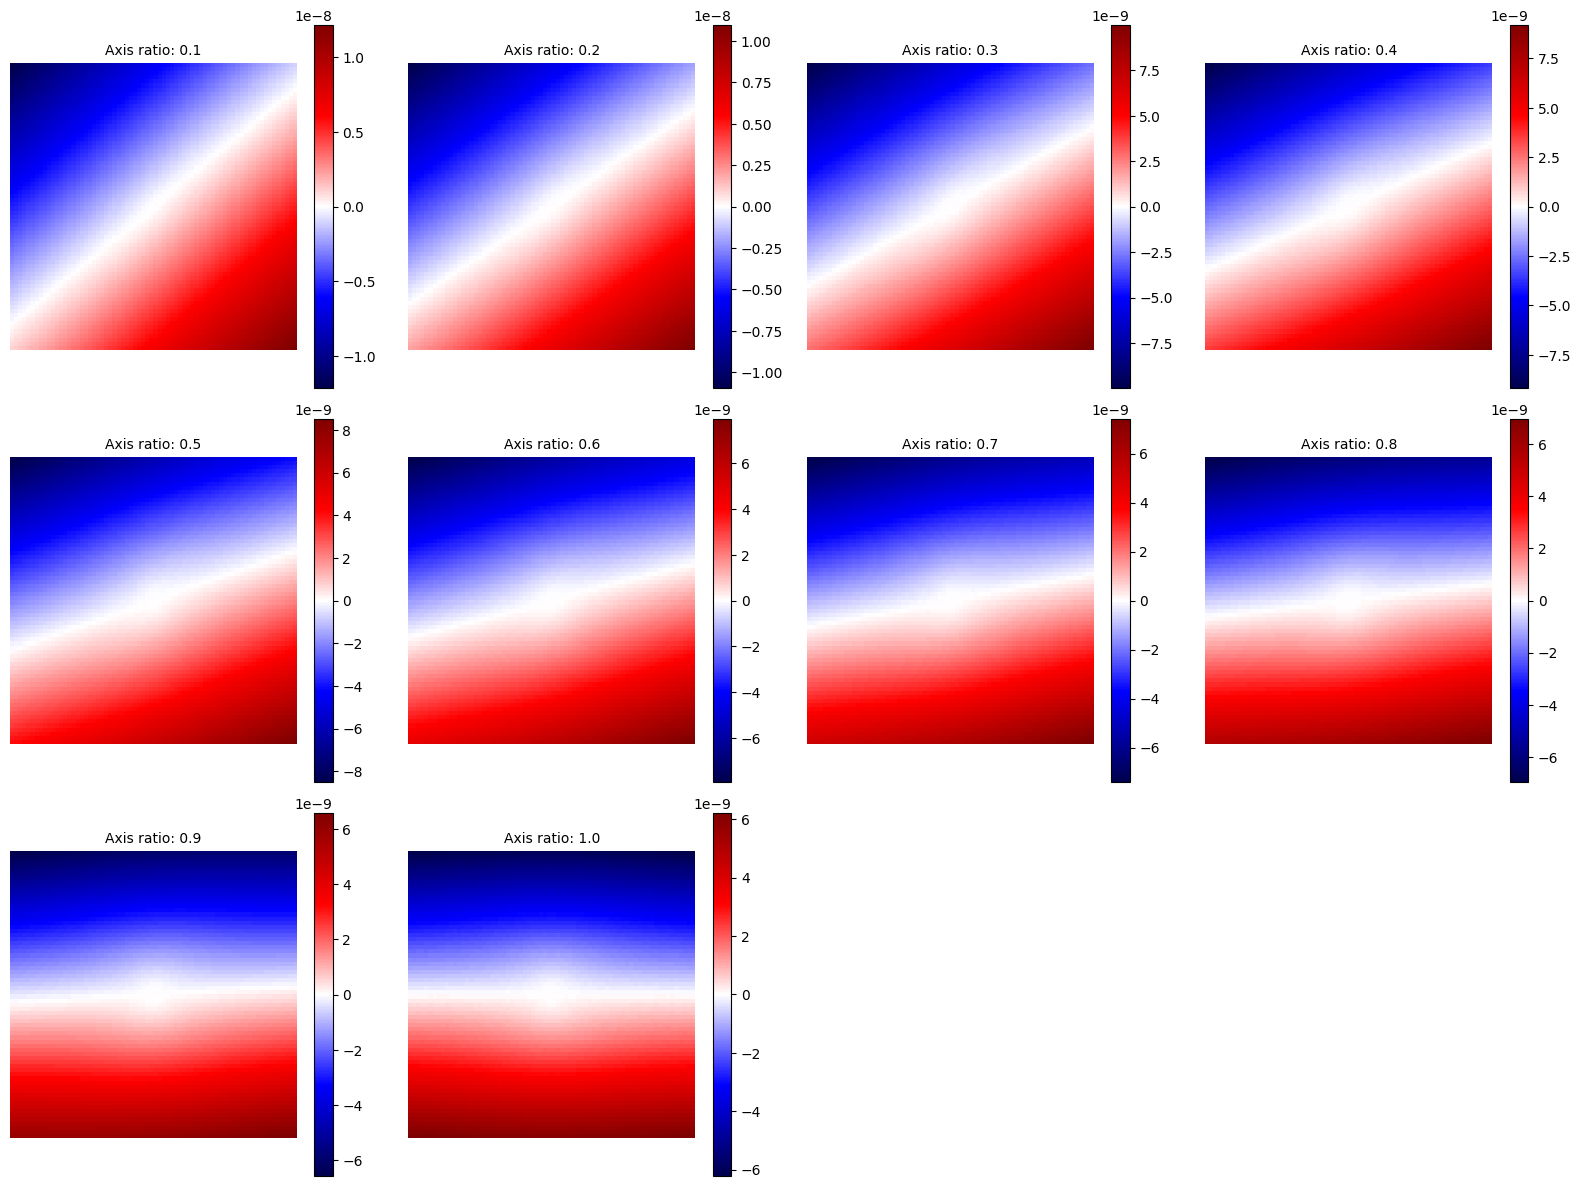

In [21]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

sampling_step = 7
x_sample = xgrid[::sampling_step, ::sampling_step]
y_sample = ygrid[::sampling_step, ::sampling_step]
arrow_scale = 0.25
head_width = 5
head_length = 6

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)

    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.1,rs=1e8, b0=1.0
    )
    mass_piemd=PIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.1,b0=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

    deflections_dpiemd = mass_dpiemd.deflections_yx_2d_from(grid=grid).native
    deflections_piemd = mass_piemd.deflections_yx_2d_from(grid=grid).native
    model_image_test = bulge.image_2d_from(grid=grid).native

    deflections_x_dpiemd = deflections_dpiemd[:,:, 0]
    deflections_y_dpiemd = deflections_dpiemd[:,:, 1]

    deflections_x_piemd = deflections_piemd[:,:, 0]
    deflections_y_piemd = deflections_piemd[:,:, 1]

    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    # img = ax.imshow(
    #     deflections_x_dpiemd - deflections_x_sie, norm="linear", cmap="seismic", extent=ext,
    # )
    img = ax.imshow(
        deflections_x_dpiemd - deflections_x_piemd, norm="linear", cmap="seismic", extent=ext,
    )

    ax.set_title(f"Axis ratio: {axis_ratio}", fontsize=10)
    fig.colorbar(img, ax=ax)

    ax.axis("off")
for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()


#### 3.1.3 Residual(Y)

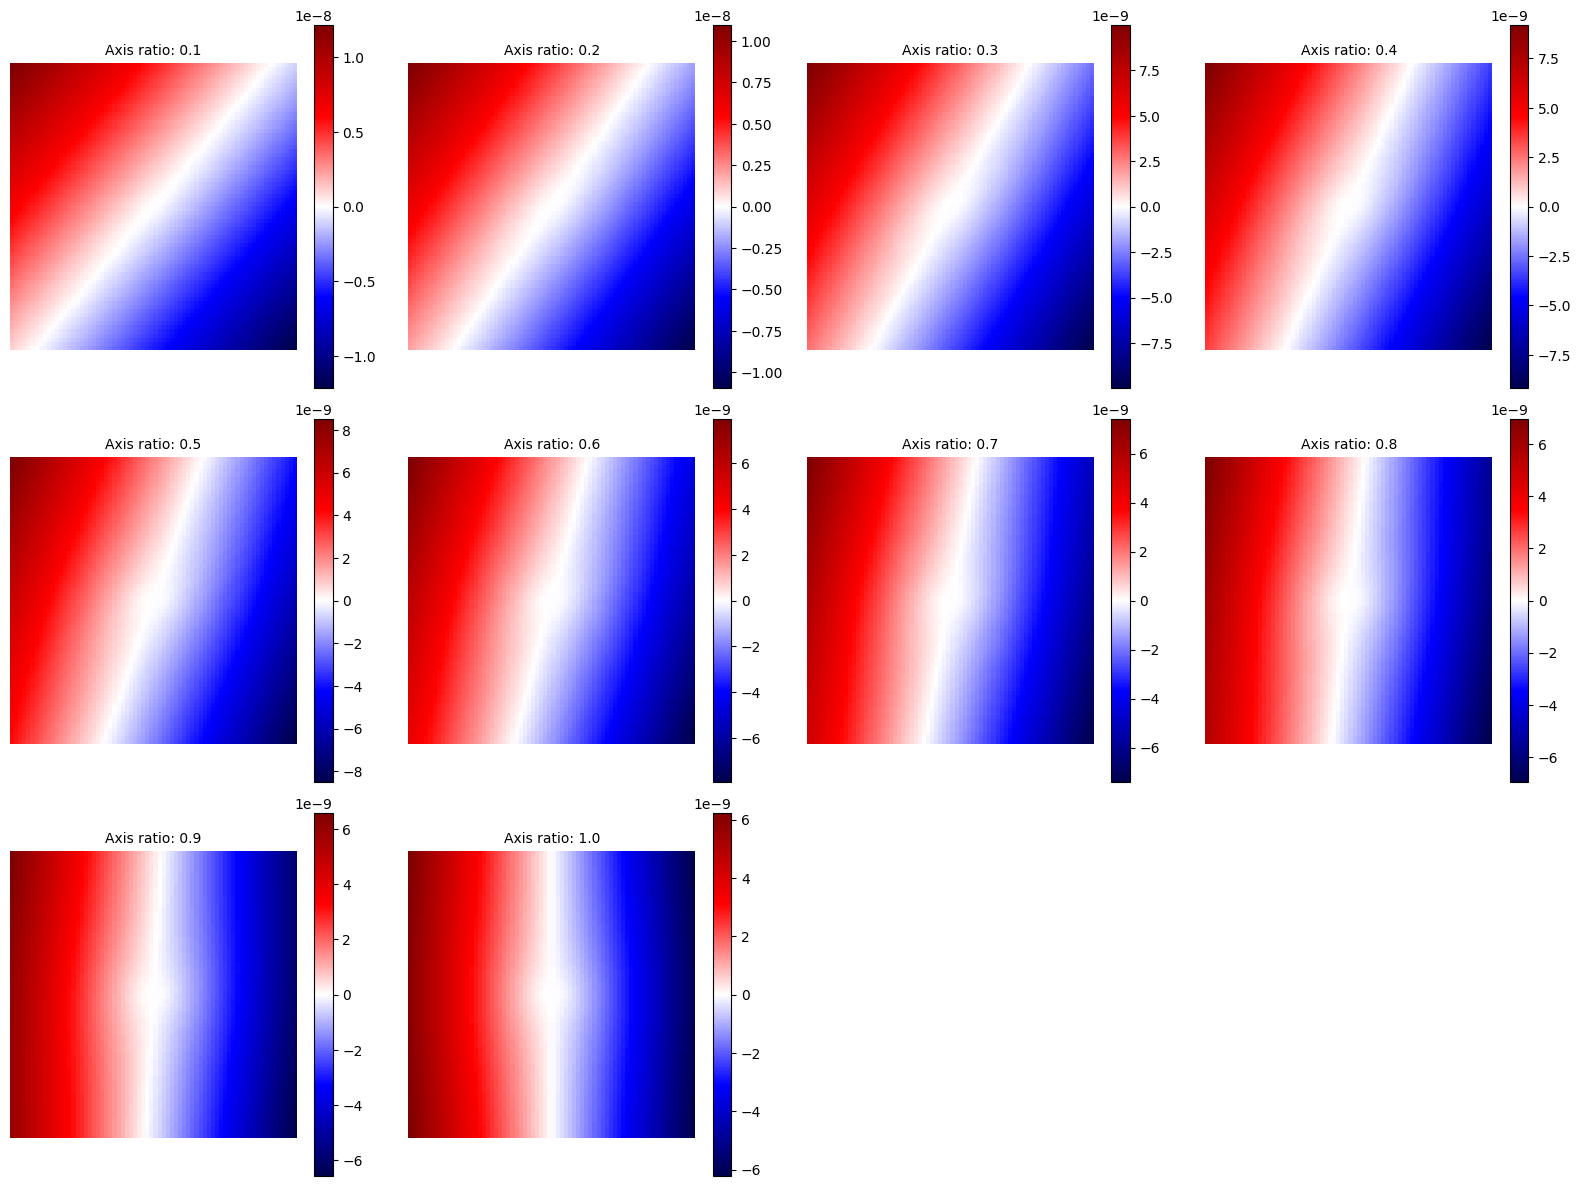

In [22]:
axis_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angle = 45

xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 4
rows = -(-len(axis_ratios) // cols)
fig, axs = plt.subplots(rows, cols, figsize=(16, 4 * rows), tight_layout=True)

sampling_step = 7
x_sample = xgrid[::sampling_step, ::sampling_step]
y_sample = ygrid[::sampling_step, ::sampling_step]
arrow_scale = 0.25
head_width = 5
head_length = 6

for i, axis_ratio in enumerate(axis_ratios):
    ell_comps = al.convert.ell_comps_from(axis_ratio=axis_ratio, angle=angle)

    mass_dpiemd=dPIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.1,rs=1e8, b0=1.0
    )
    mass_piemd=PIEMD(
        centre=(0, 0), ell_comps=ell_comps,
        ra=0.1,b0=1.0
    )
    bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

    deflections_dpiemd = mass_dpiemd.deflections_yx_2d_from(grid=grid).native
    deflections_piemd = mass_piemd.deflections_yx_2d_from(grid=grid).native
    model_image_test = bulge.image_2d_from(grid=grid).native

    deflections_x_dpiemd = deflections_dpiemd[:,:, 0]
    deflections_y_dpiemd = deflections_dpiemd[:,:, 1]

    deflections_x_piemd = deflections_piemd[:,:, 0]
    deflections_y_piemd = deflections_piemd[:,:, 1]

    row, col = divmod(i, cols)
    ax = axs[row, col] if rows > 1 else axs[col]

    # img = ax.imshow(
    #     deflections_x_dpiemd - deflections_x_sie, norm="linear", cmap="seismic", extent=ext,
    # )
    img = ax.imshow(
        deflections_y_dpiemd - deflections_y_piemd, norm="linear", cmap="seismic", extent=ext,
    )

    ax.set_title(f"Axis ratio: {axis_ratio}", fontsize=10)
    fig.colorbar(img, ax=ax)

    ax.axis("off")
for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()

## 4 Comparison between dPIEMDSph with SIS
> test if the fast caculation accurate in circular situation

### 4.1 Test deflection angle

#### 4.1.1 Vector Field

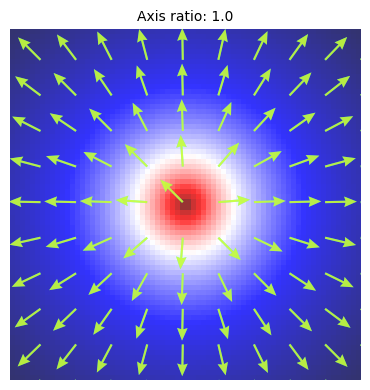

In [23]:
xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 1
rows = 1
fig = plt.figure(figsize=(4, 4), tight_layout=True)
axs = fig.add_subplot(1, 1, 1)


sampling_step = 7
x_sample = xgrid[::sampling_step, ::sampling_step]
y_sample = ygrid[::sampling_step, ::sampling_step]
arrow_scale = 0.25
head_width = 5
head_length = 6

mass_dpiemdsph=dPIEMDSph(
    centre=(0, 0),
    ra=0.0,rs=1e8, b0=1.0
)
mass_sis=al.mp.IsothermalSph(
    centre=(0, 0),
    einstein_radius=1.0
)
bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

deflections_dpiemdsph = mass_dpiemdsph.deflections_yx_2d_from(grid=grid).native
deflections_sis = mass_sis.deflections_yx_2d_from(grid=grid).native
model_image_test = bulge.image_2d_from(grid=grid).native

deflections_x_dpiemdsph = deflections_dpiemdsph[::sampling_step, ::sampling_step, 0]
deflections_y_dpiemdsph = deflections_dpiemdsph[::sampling_step, ::sampling_step, 1]

deflections_x_sis = deflections_sis[::sampling_step, ::sampling_step, 0]
deflections_y_sis = deflections_sis[::sampling_step, ::sampling_step, 1]

row, col = divmod(i, cols)

axs.quiver(
    x_sample, y_sample, deflections_x_dpiemdsph, deflections_y_dpiemdsph,
    color="cyan",
    scale=1 / arrow_scale,
    scale_units="xy",
    headwidth=head_width,
    headlength=head_length,
    headaxislength=head_length * 0.9,
    alpha=0.7
)

axs.quiver(
    x_sample, y_sample, deflections_x_sis, deflections_y_sis,
    color="yellow",
    scale=1 / arrow_scale,
    scale_units="xy",
    headwidth=head_width,
    headlength=head_length,
    headaxislength=head_length * 0.9,
    alpha=0.7
)

axs.imshow(
    model_image_test, norm="log", cmap="seismic", extent=ext, alpha=0.8
)

axs.set_title(f"Axis ratio: {1.0}", fontsize=10)

axs.axis("off")
for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()


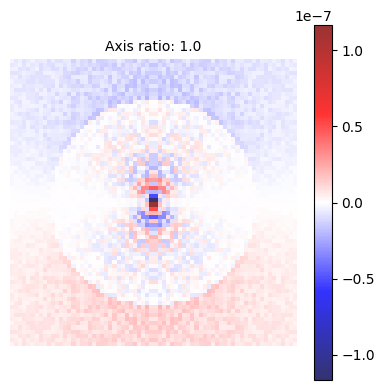

In [24]:
xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 1
rows = 1
fig = plt.figure(figsize=(4, 4), tight_layout=True)
axs = fig.add_subplot(1, 1, 1)


sampling_step = 7
x_sample = xgrid[::sampling_step, ::sampling_step]
y_sample = ygrid[::sampling_step, ::sampling_step]
arrow_scale = 0.25
head_width = 5
head_length = 6

mass_dpiemdsph=dPIEMDSph(
    centre=(0, 0),
    ra=0.0,rs=1e8, b0=1.0
)
mass_sis=al.mp.IsothermalSph(
    centre=(0, 0),
    einstein_radius=1.0
)
bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

deflections_dpiemdsph = mass_dpiemdsph.deflections_yx_2d_from(grid=grid).native
deflections_sis = mass_sis.deflections_yx_2d_from(grid=grid).native
model_image_test = bulge.image_2d_from(grid=grid).native

deflections_x_dpiemdsph = deflections_dpiemdsph[:, :, 0]
deflections_y_dpiemdsph = deflections_dpiemdsph[:, :, 1]

deflections_x_sis = deflections_sis[:, :, 0]
deflections_y_sis = deflections_sis[:, :, 1]

row, col = divmod(i, cols)

img = axs.imshow(
    deflections_x_dpiemdsph - deflections_x_sis, norm="linear", cmap="seismic", extent=ext, alpha=0.8
)

axs.set_title(f"Axis ratio: {1.0}", fontsize=10)
fig.colorbar(img, ax=axs)

axs.axis("off")
for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()


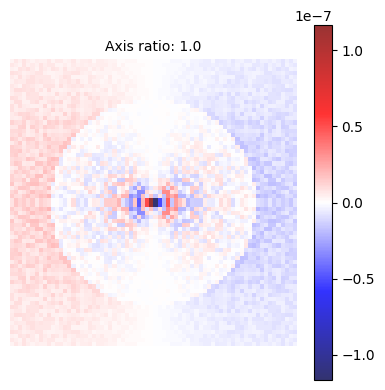

In [25]:
xgrid = grid.native[:, :, 0]
ygrid = grid.native[:, :, 1]
ext = [xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()]

cols = 1
rows = 1
fig = plt.figure(figsize=(4, 4), tight_layout=True)
axs = fig.add_subplot(1, 1, 1)


sampling_step = 7
x_sample = xgrid[::sampling_step, ::sampling_step]
y_sample = ygrid[::sampling_step, ::sampling_step]
arrow_scale = 0.25
head_width = 5
head_length = 6

mass_dpiemdsph=dPIEMDSph(
    centre=(0, 0),
    ra=0.0,rs=1e8, b0=1.0
)
mass_sis=al.mp.IsothermalSph(
    centre=(0, 0),
    einstein_radius=1.0
)
bulge=al.lp.Sersic(centre=(0, 0), ell_comps=ell_comps)

deflections_dpiemdsph = mass_dpiemdsph.deflections_yx_2d_from(grid=grid).native
deflections_sis = mass_sis.deflections_yx_2d_from(grid=grid).native
model_image_test = bulge.image_2d_from(grid=grid).native

deflections_x_dpiemdsph = deflections_dpiemdsph[:, :, 0]
deflections_y_dpiemdsph = deflections_dpiemdsph[:, :, 1]

deflections_x_sis = deflections_sis[:, :, 0]
deflections_y_sis = deflections_sis[:, :, 1]

row, col = divmod(i, cols)

img = axs.imshow(
    deflections_y_dpiemdsph - deflections_y_sis, norm="linear", cmap="seismic", extent=ext, alpha=0.8
)

axs.set_title(f"Axis ratio: {1.0}", fontsize=10)
fig.colorbar(img, ax=axs)

axs.axis("off")
for j in range(len(axis_ratios), rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.show()


## 5 Test the analytical and numerical method
> Assess the discrepancy between analytically computed results and those obtained via numerical differentiation

### 5.1 PIEMD

#### 5.1.1 Hessian

In [26]:
mass_piemd=PIEMD(
    centre=(0, 0), ell_comps=(0, 0),
    ra=0.1,b0=1.0
)

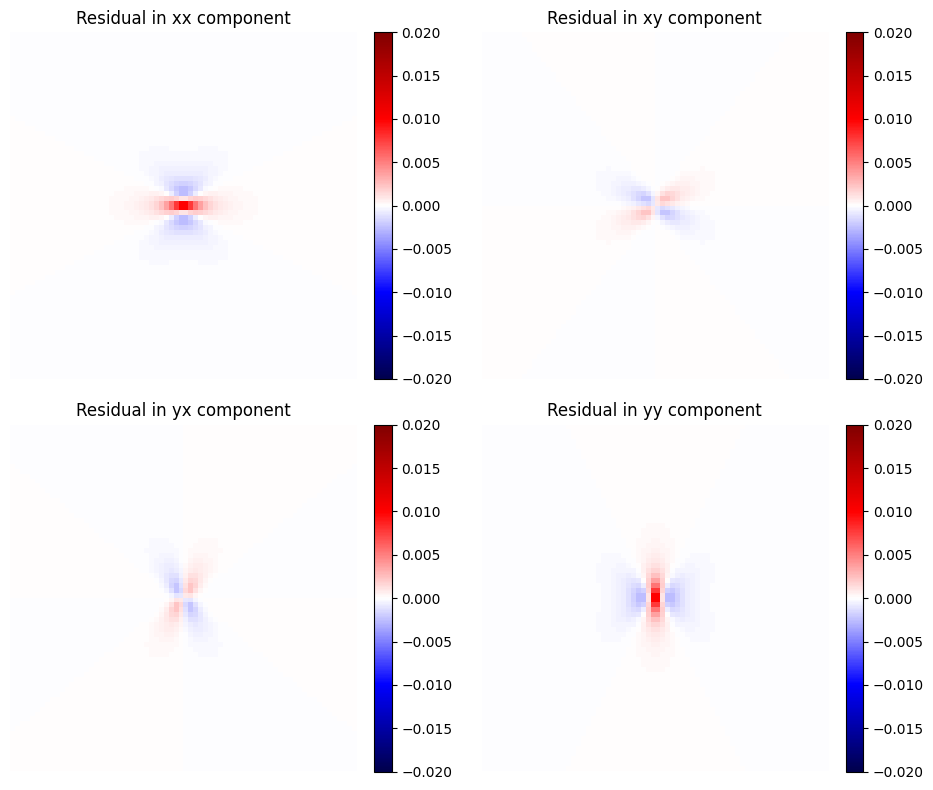

In [27]:
Hessian_A = mass_piemd.analytical_hessian_2d_from(grid=grid)
Hessian_N = mass_piemd.hessian_from(grid=grid)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

titles = ['xx component', 'xy component', 'yx component', 'yy component']

for i, ax in enumerate(axes.flat):
    diff = Hessian_A[i].reshape(70, 70) - Hessian_N[i].reshape(70, 70)
    im = ax.imshow(diff, origin='lower', cmap='seismic',vmax=0.02,vmin=-0.02)
    ax.set_title(f'Residual in {titles[i]}')
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


#### 5.1.2 Magnification from hessian

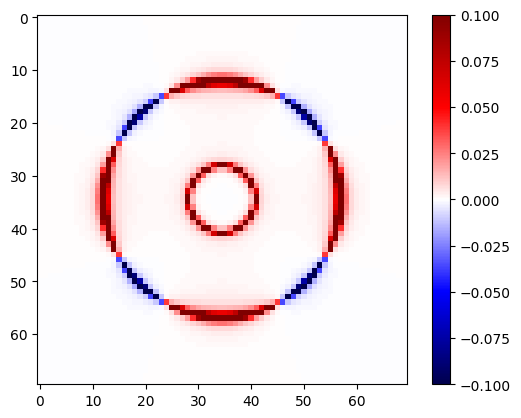

In [28]:
mu_map_A = mass_piemd.analytical_magnification_2d_from(grid=grid).native
mu_map_N = mass_piemd.magnification_2d_via_hessian_from(grid=grid).reshape(70,70)

plt.imshow(mu_map_A - mu_map_N,norm="linear", cmap="seismic",vmax=0.1,vmin=-0.1)
plt.colorbar()

### 5.2 dPIEMD

#### 5.2.1 Hessian

In [29]:
mass_dpiemd=dPIEMD(
    centre=(0, 0), ell_comps=(0, 0),
    ra=0.1,rs=10.0,b0=1.0
)

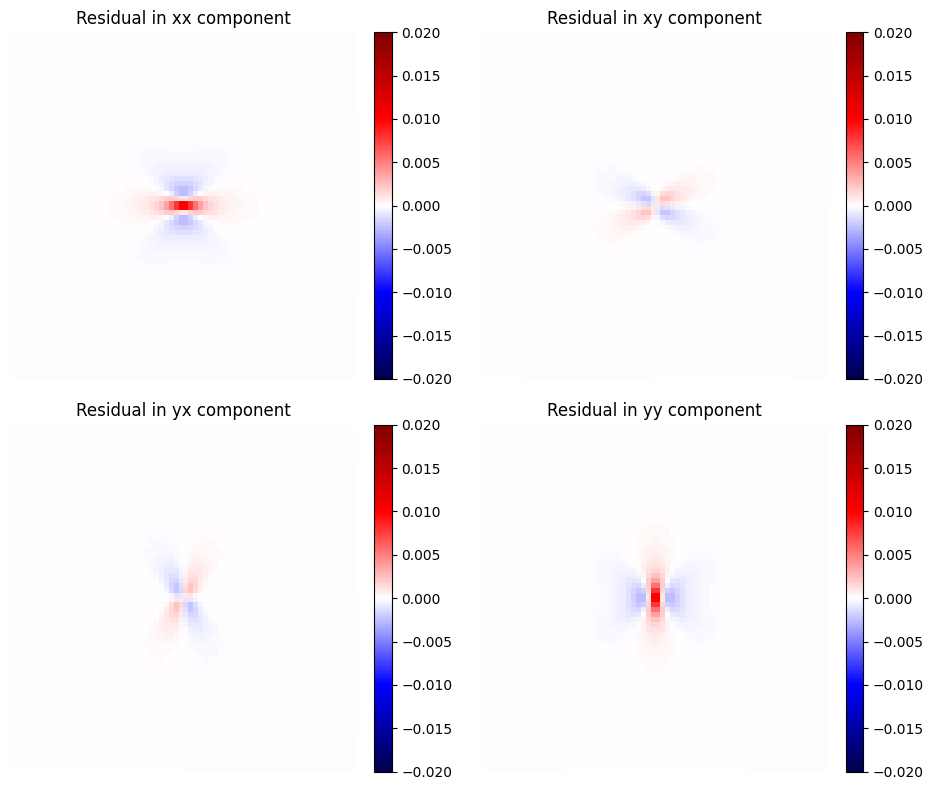

In [30]:
Hessian_A = mass_dpiemd.analytical_hessian_2d_from(grid=grid)
Hessian_N = mass_dpiemd.hessian_from(grid=grid)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

titles = ['xx component', 'xy component', 'yx component', 'yy component']

for i, ax in enumerate(axes.flat):
    diff = Hessian_A[i].reshape(70, 70) - Hessian_N[i].reshape(70, 70)
    im = ax.imshow(diff, origin='lower', cmap='seismic',vmax=0.02,vmin=-0.02)
    ax.set_title(f'Residual in {titles[i]}')
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


#### 5.2.2 Mganification from hessian

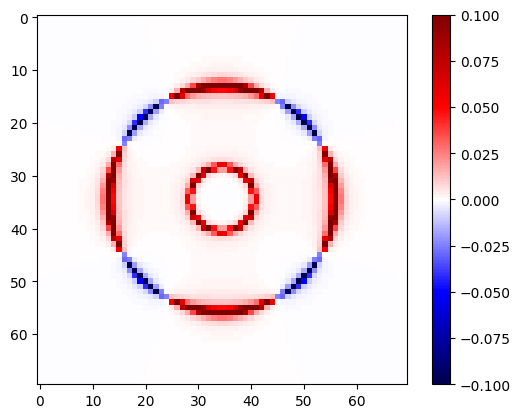

In [31]:
mu_map_A = mass_dpiemd.analytical_magnification_2d_from(grid=grid).native
mu_map_N = mass_dpiemd.magnification_2d_via_hessian_from(grid=grid).reshape(70,70)

plt.imshow(mu_map_A - mu_map_N,norm="linear", cmap="seismic",vmax=0.1,vmin=-0.1)
plt.colorbar()

### 5.3 dPIEMDSph

#### 5.3.1 Hessian

In [32]:
mass_dpiemdsph=dPIEMDSph(
    centre=(0, 0),
    ra=0.1,rs=10.0,b0=1.0
)

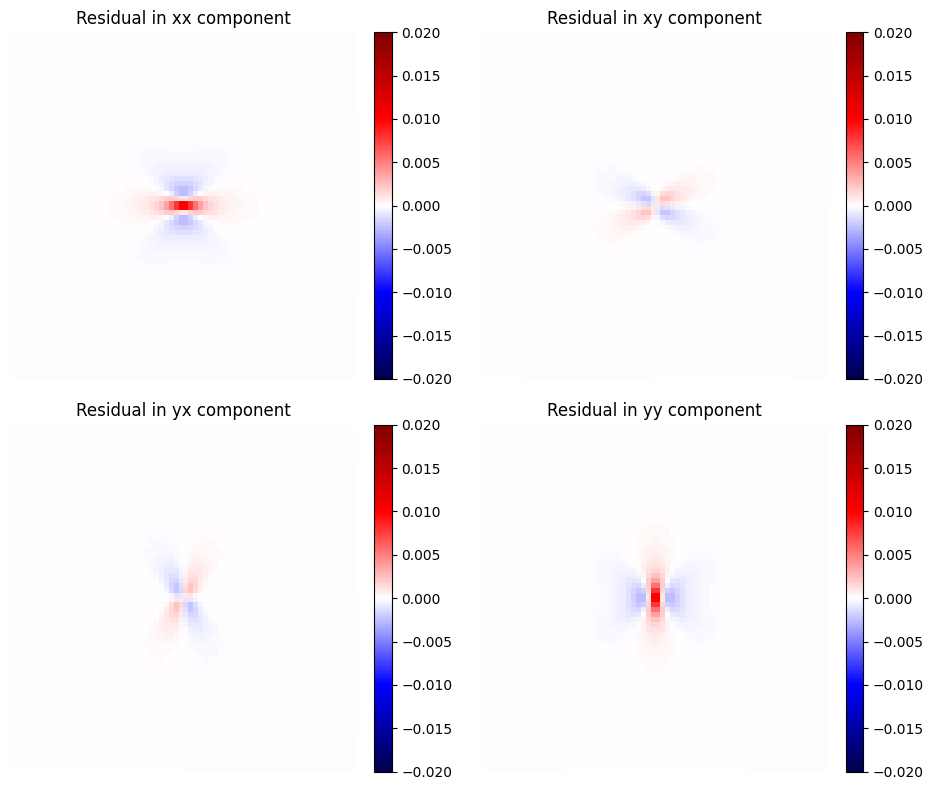

In [33]:
Hessian_A = mass_dpiemd.analytical_hessian_2d_from(grid=grid)
Hessian_N = mass_dpiemd.hessian_from(grid=grid)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

titles = ['xx component', 'xy component', 'yx component', 'yy component']

for i, ax in enumerate(axes.flat):
    diff = Hessian_A[i].reshape(70, 70) - Hessian_N[i].reshape(70, 70)
    im = ax.imshow(diff, origin='lower', cmap='seismic',vmax=0.02,vmin=-0.02)
    ax.set_title(f'Residual in {titles[i]}')
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


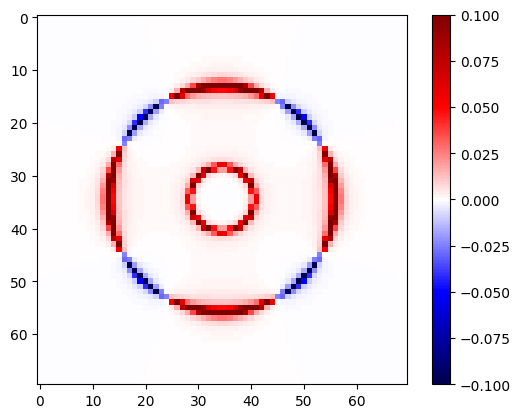

In [34]:
mu_map_A = mass_dpiemdsph.analytical_magnification_2d_from(grid=grid).native
mu_map_N = mass_dpiemdsph.magnification_2d_via_hessian_from(grid=grid).reshape(70,70)

plt.imshow(mu_map_A - mu_map_N,norm="linear", cmap="seismic",vmax=0.1,vmin=-0.1)
plt.colorbar()